<a href="https://colab.research.google.com/github/Anton2181/MUMIA/blob/main/Badanie_zdolnosci_generalizacyjnych_sieci_neuronowych.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Badanie zdolności generalizacyjnych sieci neuronowych**


---

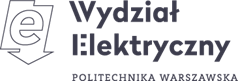
  

#### Zakład Elektrotechniki Teoretycznej i Informatyki Stosowanej
#### Instytut Elektrotechniki Teoretycznej i Systemów Informacyjno-Pomiarowych
#### Wydział Elektryczny, Politechnika Warszawska
  
Autor: mgr inż. Aleksandra Osowska-Kurczab

## **Importy bibliotek**

Import standardowych bibliotek i funkcji wykorzystywanych w ćwiczeniu.

In [1]:
import re

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib import gridspec

import tensorflow_hub as hub
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

!pip install scikit-learn
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.utils import check_array

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

--2025-05-29 17:07:02--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2025-05-29 17:07:03--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [               <=>  ]  33.20M  9.39MB/s    in 3.5s    

2025-05-29 17:07:07 (9.39 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## **Dodatkowe funkcje**

Biblioteka dodatkowych funkcji wykorzystywanych w ćwiczeniu. Nie trzeba się z nią dokładnie zapoznawać, chyba, że treść ćwiczenia mówi inaczej.


In [2]:
RANDOM_SEED=123
torch.manual_seed(RANDOM_SEED)

In [3]:
# torch.backends.cudnn.enabled = False
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [4]:
def read_MNIST(bs_train: int, bs_test: int, mode: str = 'zad2a'):
    if mode == 'zad2a':
        transformation_pipeline = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])
    elif mode == 'zad2b':
        transformation_pipeline = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])
    else:
        raise

    train_dataset = torchvision.datasets.MNIST('./',
                                               train=True,
                                               download=True,
                                               transform=transformation_pipeline)
    train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset,
                                                                 [50000, 10000])
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size_train,
                                               shuffle=True,
                                               worker_init_fn=np.random.seed(RANDOM_SEED))
    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=batch_size_train,
                                               shuffle=True,
                                               worker_init_fn=np.random.seed(RANDOM_SEED))

    test_dataset = torchvision.datasets.MNIST('./',
                                              train=False,
                                              download=True,
                                              transform=transformation_pipeline)
    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=batch_size_test,
                                              shuffle=True,
                                               worker_init_fn=np.random.seed(RANDOM_SEED))

    if mode == 'zad2a':
        return list(train_loader)[:15], list(valid_loader)[:60], test_loader
    elif mode == 'zad2b':
        return list(train_loader)[:500], valid_loader, test_loader
    else:
        raise

In [5]:
class Clean20NewsGroup:
    @staticmethod
    def clean_20newsgroup(dataset: list):
        stopword_list = list(set(stopwords.words('english')))+["'m", "'ll", "'d", "'ve"]
        dataset = [Clean20NewsGroup.clean_starting_lines(post) for post in dataset]
        dataset = [Clean20NewsGroup.delete_stopwords(post, stopword_list) for post in dataset]
        dataset = [Clean20NewsGroup.clean_special_chars(post) for post in dataset]
        dataset = [Clean20NewsGroup.clean_duplicate_whitespaces(post) for post in dataset]
        dataset = [post.lower() for post in dataset]
        return dataset

    @staticmethod
    def clean_duplicate_whitespaces(post: str):
        return re.sub('[ ]+', ' ', post)

    @staticmethod
    def clean_special_chars(post: str):
        return re.sub('[^A-Za-z0-9 .,?!-]+', '', post)

    @staticmethod
    def delete_stopwords(post: str, stopword_list: list):
        word_tokens = word_tokenize(post)
        return ' '.join([w for w in word_tokens if not w in stopword_list])

    @staticmethod
    def clean_starting_lines(post: str):
        to_remove = ('From:', 'Subject:', 'Reply-To:', 'In-Reply-To:', 'Nntp-Posting-Host:', 'Organization:', 'X-Mailer:', 'In article <', 'Lines:', 'NNTP-Posting-Host:', 'Summary:', 'Article-I.D.:', 'Distribution:')
        return ' '.join([line.strip() for line in post.splitlines() if (not line.startswith(to_remove)) and (len(line)!=0)])

In [6]:
class VanillaNet(nn.Module):
    def __init__(self, hidden_size: int):
        super(VanillaNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

In [7]:
class ConvNet(nn.Module):
    def __init__(self, hidden_size: int):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout2d = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(320, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.dropout2d(self.conv2(x)), 2))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [8]:
class USEEmbeddingVectorizer(object):
    def __init__(self):
        self.embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
        self.batch_size = 5

    def fit(self, X, y):
        return self

    def transform(self, X):
        X_embedded = []
        [X_embedded.extend(self.embed(btc)) for btc in self.batch(X, self.batch_size)]
        return X_embedded

    @staticmethod
    def batch(iterable, n=1):
        l = len(iterable)
        for ndx in range(0, l, n):
            yield iterable[ndx:min(ndx + n, l)]

In [33]:
class EarlyStopping:

    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def train_model(model: torch.nn.Module, verbose: bool = False):

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []

    all_train_losses = []
    all_valid_losses = []

    train_error_per_epoch = []
    valid_error_per_epoch = []

    # accuracy numerator
    correct_train = 0
    acc_all_train = 0
    correct_valid = 0
    acc_all_valid = 0

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=verbose)

    for epoch in range(1, NUM_EPOCHS + 1):

        ###################
        # train the model #
        ###################
        model.train()
        for batch, (input, target) in enumerate(train_loader, 1):
            input = input.to(DEVICE)
            target = target.to(DEVICE)
            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

            _, pred = torch.max(output, 1)
            correct = np.squeeze(pred.eq(target.data.view_as(pred)))
            correct_train += correct.sum().item()
            acc_all_train += correct.shape[0]

        ######################
        # validate the model #
        ######################
        model.eval()
        for input, target in valid_loader:
            input = input.to(DEVICE)
            target = target.to(DEVICE)
            output = model(input)
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

            _, pred = torch.max(output, 1)
            correct = np.squeeze(pred.eq(target.data.view_as(pred)))
            correct_valid += correct.sum().item()
            acc_all_valid += correct.shape[0]

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        # calculate accuracy per epoch
        train_acc = correct_train/acc_all_train
        valid_acc = correct_valid/acc_all_valid

        epoch_len = len(str(NUM_EPOCHS))

        if verbose:
            print_msg = (f'[{epoch:>{epoch_len}}/{NUM_EPOCHS:>{epoch_len}}] | ' +
                        f'train_loss: {train_loss:.5f} ' +
                        f'valid_loss: {valid_loss:.5f} | ' +
                        f'train_acc: {100*train_acc:.2f}% ' +
                        f'valid_acc: {100*valid_acc:.2f}%')
            print(print_msg)

        all_train_losses.extend(train_losses)
        all_valid_losses.extend(valid_losses)

        train_error_per_epoch.append(100-100*correct_train/acc_all_train)
        valid_error_per_epoch.append(100-100*correct_valid/acc_all_valid)

        train_losses = []
        valid_losses = []
        correct_train = 0
        acc_all_train = 0
        correct_valid = 0
        acc_all_valid = 0

        early_stopping(valid_loss, model)

        if early_stopping.early_stop and verbose:
            print("Early stopping")
            break

        scheduler.step()

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses, all_train_losses, all_valid_losses, train_error_per_epoch, valid_error_per_epoch

def test_model(model: torch.nn.Module, verbose: bool = False):
    test_loss = 0.0
    class_correct = list(0. for i in range(NUM_CLASSES))
    class_total = list(0. for i in range(NUM_CLASSES))
    predictions_total = []
    targets_total = []

    model.eval()
    for input, target in test_loader:
        if len(target.data) != batch_size_test:
            break
        input = input.to(DEVICE)
        target = target.to(DEVICE)
        output = model(input)
        loss = criterion(output, target)
        test_loss += loss.item()*input.size(0)
        _, pred = torch.max(output, 1)
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        for i in range(batch_size_test):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            predictions_total.append(pred[i].item())
            targets_total.append(target[i].item())

    test_loss = test_loss/len(test_loader.dataset)
    test_acc = 100. * np.sum(class_correct) / np.sum(class_total)

    if verbose:
        msg = 'Test Loss: {:.6f}\n'.format(test_loss)
        print(msg)

        for i in range(NUM_CLASSES):
            if class_total[i] > 0:
                print('Test precision of %1s: %4d%% (%2d/%2d)' % (
                    str(classes[i]), 100 * class_correct[i] / class_total[i],
                    np.sum(class_correct[i]), np.sum(class_total[i])))
            else:
                print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        msg = '\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (test_acc,
                                                              np.sum(class_correct),
                                                              np.sum(class_total))
        print(msg)

    return predictions_total, targets_total, 100-test_acc

In [10]:
class RegressScoring:
    def __init__(self, y_true, y_pred, x):
        self.y_pred = y_pred
        self.y_true = y_true
        self.x = x

    def score(self, model):
        mse = self.mean_sqr_error(self.y_true, self.y_pred)
        mape = self.mean_avg_per_error(self.y_true, self.y_pred)
        model_score = self.model_scoring(self.x, self.y_true, model)
        return mse, mape, model_score

    @staticmethod
    def mean_avg_per_error(y_true, y_pred):
        # y_true, y_pred = check_array(y_true, y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    @staticmethod
    def mean_sqr_error(y_true, y_pred):
        return mean_squared_error(y_true, y_pred)

    @staticmethod
    def model_scoring(x, y_true, model):
        return model.score(x, y_true)

In [11]:
class ClassifyScoring:
    def __init__(self, y_true, y_pred, target_names, verbose=False):
        self.y_pred = y_pred
        self.y_true = y_true
        self.target_names = target_names
        self.verbose = verbose

    def print_report(self):
        print('='*5, 'CLASSIFICATION REPORT', '='*5)
        print(classification_report(self.y_true, self.y_pred, target_names=self.target_names))

    def conf_mat(self):
        if self.verbose==True:
            self.plot_conf_mat()
        return confusion_matrix(self.y_true, self.y_pred)

    def plot_conf_mat(self):
        fig = plt.figure(figsize=(10,10))
        cm = confusion_matrix(self.y_true, self.y_pred)
        sn.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True, xticklabels=self.target_names, yticklabels=self.target_names)
        plt.title('Confusion matrix')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()

    def score(self):
        if self.verbose == True:
            print('='*5, 'TESTING RESULTS', '='*5)
            display(pd.DataFrame({
                'ACC': accuracy_score(self.y_true, self.y_pred),
                'PREC': precision_score(self.y_true, self.y_pred, average='weighted'),
                'REC': recall_score(self.y_true, self.y_pred, average='weighted'),
                'F1': f1_score(self.y_true, self.y_pred, average='weighted')
            }, index=[0]))
        return [accuracy_score(self.y_true, self.y_pred),
                precision_score(self.y_true, self.y_pred, average='weighted'),
                recall_score(self.y_true, self.y_pred, average='weighted'),
                f1_score(self.y_true, self.y_pred, average='weighted')]

In [12]:
def plot_learning_curves(train_loss: list, valid_loss: list, all_train_losses: list, all_valid_losses: list):

    max_loss = np.max(all_train_losses + all_valid_losses)

    fig = plt.figure(num=3, figsize=(10,4))
    plt.plot(range(1,len(train_loss)+1), train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1), valid_loss, label='Validation Loss')
    minposs = valid_loss.index(min(valid_loss))+1
    plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, max_loss)
    plt.xlim(0, len(train_loss)+1)
    plt.grid(True)
    plt.title('Loss per epoch')
    plt.legend(loc='upper right')
    plt.tight_layout()

    fig, ax = plt.subplots(2,1,num=4, figsize=(10,8))
    ax[0].plot(range(1,len(all_train_losses)+1), all_train_losses, label='Training Loss')
    for idx in range(NUM_EPOCHS):
        ax[0].axvline(idx*len(all_train_losses)/(len(train_loss)+1), linestyle='--', color='lightgray')
    ax[0].set_ylabel('loss')
    ax[0].set_ylim(0, max_loss)
    ax[0].set_xlim(0, len(all_train_losses)+1)
    ax[0].grid(True)
    ax[0].set_title('Loss per batch')
    ax[0].legend(loc='upper right')

    ax[1].plot(range(1,len(all_valid_losses)+1), all_valid_losses, label='Validation Loss', color='orange')
    for idx in range(NUM_EPOCHS):
        plt.axvline(idx*len(all_valid_losses)/(len(train_loss)+1), linestyle='--', color='lightgray')
    ax[1].set_xlabel('batches')
    ax[1].set_ylabel('loss')
    ax[1].set_ylim(0, max_loss)
    ax[1].set_xlim(0, len(all_valid_losses)+1)
    ax[1].grid(True)
    ax[1].legend(loc='upper right')
    plt.tight_layout()
    plt.show()

In [47]:
def show_example_predictions(model: torch.nn.Module):
    dataiter = iter(test_loader)
    images, labels = next(dataiter)[:]
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    outputs = model(images)
    _, preds = torch.max(outputs.data, 1)

    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(batch_size_test):
        ax = fig.add_subplot(2, int(batch_size_test/2), idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx].cpu().numpy()), cmap='gray')
        ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    plt.suptitle('Example predictions on single batch from testing set')
    plt.tight_layout()
    plt.show()

## **Program ćwiczenia**

Tematem laboratorium jest zagadnienie ***generalizacji***. W najprostszych słowach generalizacja to właściwe działanie systemu na danych wejściowych, które nie uczestniczyły w uczeniu (na danych testujących). Celem uczenia sieci jest taka adaptacja wag, aby na podstawie próbek uczących (które dobrze reprezentują modelowany proces) nauczyć się wzorców modelowanego procesu. Celem nie jest *tylko* dopasowanie się do próbek uczących.

Aby zobrazować zjawisko generalizacji wyobraźmy sobie przypadek modelowania funkcji jednej zmiennej.

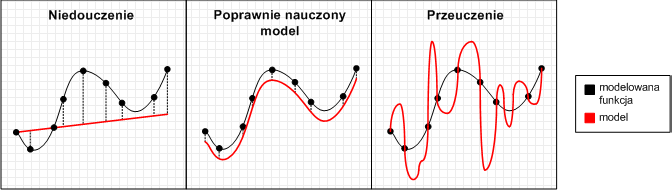

Załóżmy, że czarne punkty to próbki uczące, ciemną linią zaznaczono modelowaną funkcję, a czerwoną stworzony model. Gdy mamy do czynienia z **niedouczeniem**, model zakłada zbyt duże uproszczenia, przez które utracono charakter procesu. Przypadek **przeuczenia** to stan, w którym dane uczące są idealnie odwzorowane, niestety nadmierna ekspresja modelu (zbyt duża liczba parametrów = stopni swobody) powoduje, że model jest bezużyteczny dla danych nieuczestniczących w uczeniu. Może się to objawiać generowaniem silnie zaszumionych wartości, silnym rozchwianiem lub nadmiernym dopasowaniem do pojedynczych wzorców. Docelowo, proces uczenia ma doprowadzić do sytuacji gdy model jest w stanie w miarę dokładnie odtwarzać dane uczące, ale równocześnie uchwyca bardziej generalne trendy i wzorce w danych wejściowych.

Inna definicja wykorzystuje 2 inne, bardziej ogólne pojęcia:
- **bias** (obciążenie) - uproszczenia poczynione przez model na poczatku uczenia, aby problem był jak najprosciej rozwiazywalny,
- **variance** (wariancja) - jak bardzo musi zostac zmienione wyjście przy minimalnej zmianie wejscia (miara lokalnej *chwiejności/stabilności* modelu)  

Obydwa te człony stoją względem siebie w opozycji - zazwyczaj walcząc o obniżenie jednej wartości, podwyższamy drugą, dlatego należy dbać o kompromis (w literaturze spotkacie się Państwo z określeniem *bias-variance trade-off*).

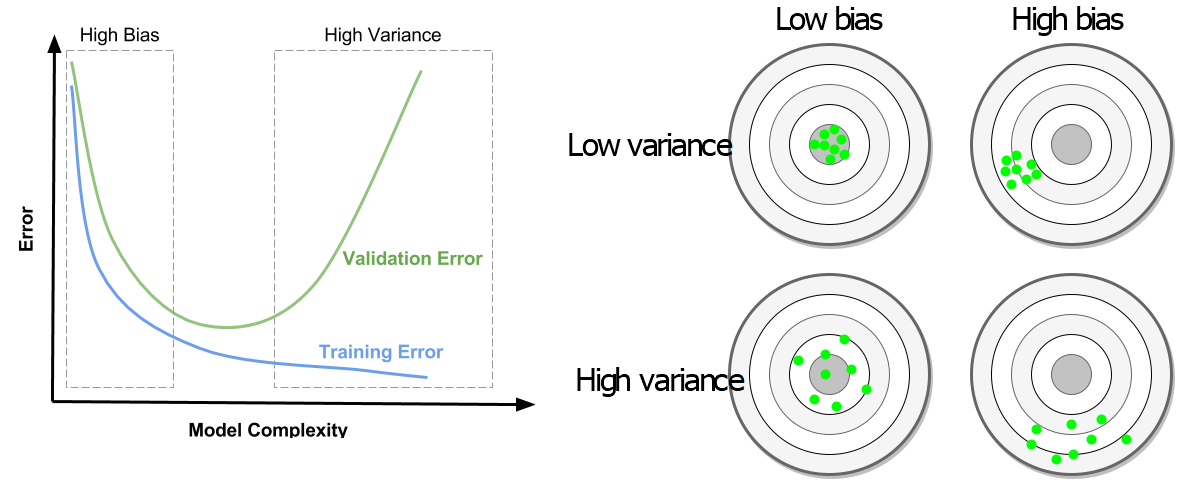

Aby dogłębnie zaznajomić się z pojęciem generalizacji zrealizujecie Państwo 3 ćwiczenia:
- **Zadanie 1** Zadanie regresji
    - Boston House Pricing dataset
    - Zadanie 1a Generalizacja vs. wielkość modelu
    - Zadanie 1b Generalizacja vs. hiperparametry modelu
- **Zadanie 2** Zadanie klasyfikacji - Wizja komputerowa
    - MNIST dataset
    - Zadanie 2a Generalizacja vs. wielkość modelu
    - Zadanie 2b Generalizacja vs. ekspresywność modelu i uwarunkowanie procesu uczenia
- \* **Zadanie 3** Zadanie klasyfikacji - Przetwarzanie języka naturalnego \* - dla chętnych
    - 20NewsGroup dataset
    - Zadanie 3 Generalizacja vs. jakość ekstraktora cech


### **Zadanie 1** Zadanie regresji

Pierwsze ćwiczenie będzie prezentować zagadnienie generalizacji na przykładzie problemu **regresji** z wykorzystaniem **drzew decyzyjnych**.

#### Boston House Pricing dataset

W ćwiczeniu będziemy budować modele regresji z użyciem danych ze zbioru Boston House Price Prediction challenge (więcej o tym zbiorze danych można poczytać np. [tutaj](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)).

Zacznijmy od zapoznania się ze zbiorym danych (proszę zwrócić uwagę na opis 13 cech oraz rozpoznać 1 zmienną objaśnianą (ang. *target*)):

In [14]:
# Load dataset
# dataset = load_boston() # load_boston has been removed from scikit-learn since version 1.2
# Instead, use the data you have already loaded:
dataset = {
    'data': data,
    'target': target,
    'feature_names': ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'], #  Add feature names for consistency with the original load_boston
    'DESCR': 'Boston house prices dataset, manually loaded from http://lib.stat.cmu.edu/datasets/boston'  # Add a description
}

# Show dataset description
print(dataset['DESCR'])

# Transform dataset into pd.DataFrame
boston_df = pd.DataFrame(dataset['data'])
boston_df.columns = dataset['feature_names']
boston_df['TARGET'] = pd.DataFrame(dataset['target'])
boston_df.head()

Boston house prices dataset, manually loaded from http://lib.stat.cmu.edu/datasets/boston


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Pierwszym krokiem będzie sprawdzenie kompletności zbioru danych oraz statystyka opisowa zmiennych (pamiętajmy, że w zbiorze znajdują się zarówno zmienne kategoryczne jak i numeryczne).


In [15]:
print('Dataset shape: ', boston_df.shape)
boston_df.describe()

Dataset shape:  (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Zauważmy, że zbiór danych jest kompletny (nie ma brakujących danych - patrz: kolumna count). To co warto zauważyć na etapie prostej analizy - zmienne są nieznormalizowane między sobą. Trzeba będzie zadbać o poprawną normalizację zanim dane wejściowe zostaną przekazane do modelu.

Aby zapoznać się z trudnością zadania modelowania ceny domów w Bostonie sprawdźmy czy zbiór danych zawiera proste korelacje między zmiennymi objaśniającymi (cechami np wskaźnikiem przestępczości, współczynnikiem liczby nauczycieli na ucznia, koncentracją związków azotu ...), a zmienną objaśnianą (ceną domów).

Top correlations between features:
[ RAD ] - [ TAX ]:  0.91
[ NOX ] - [ DIS ]:  -0.77
[ INDUS ] - [ NOX ]:  0.76
Top correlations with respect to target variable:
[ LSTAT ] - [TARGET]:  -0.74
[ RM ] - [TARGET]:  0.7
[ PTRATIO ] - [TARGET]:  -0.51


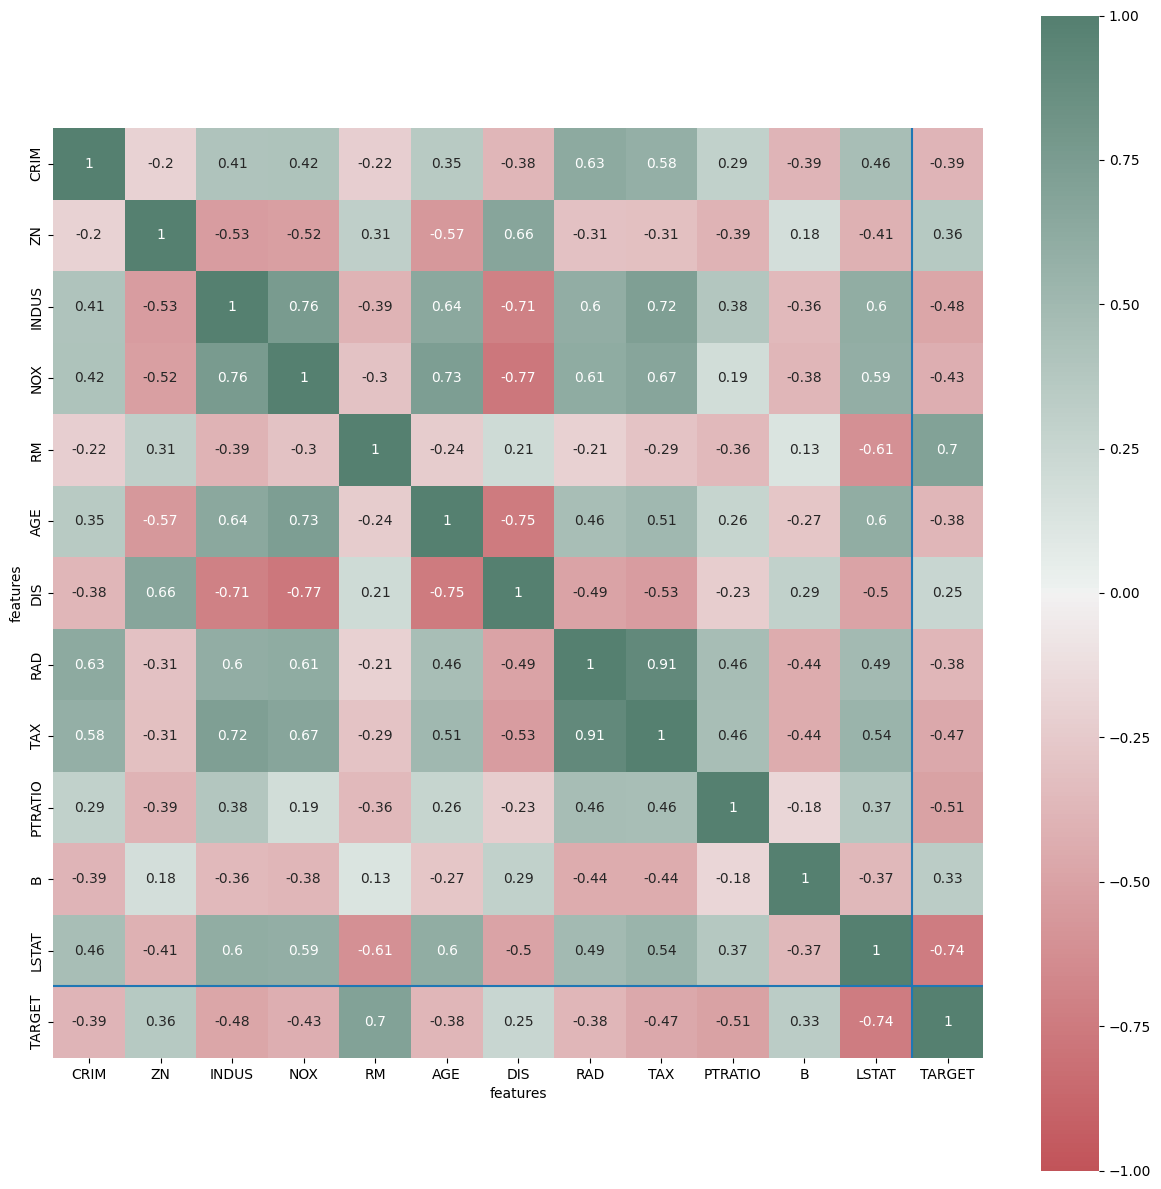

In [17]:
numerical_columns = list(boston_df.columns)
numerical_columns.remove('CHAS')

numerical_data = np.array(boston_df[numerical_columns])
corr_mat = np.corrcoef(numerical_data.T)

fig, ax = plt.subplots(figsize=(15,15))
cmap = sn.diverging_palette(10, 160, s=50, as_cmap=True)
sn.heatmap(corr_mat, annot=True, square=True, ax=ax, vmin=-1, vmax=1, cmap=cmap,
           yticklabels=numerical_columns, xticklabels=numerical_columns)
ax.hlines([12], *ax.get_xlim())
ax.vlines([12], *ax.get_xlim())
ax.set_xlabel('features')
ax.set_ylabel('features')

corr_mat_abs = np.abs(corr_mat)

print('Top correlations between features:')
upper_tri = corr_mat_abs[:-1,:-1][np.triu_indices_from(corr_mat[:-1,:-1], k=1)]
max_ind = [np.where(corr_mat_abs[:-1,:-1]==max)[0] for max in sorted(upper_tri,reverse=True)[:3]]
_ = [print('[', numerical_columns[index[0]], '] - [', numerical_columns[index[1]],']: ', round(corr_mat[index[0], index[1]],2)) for index in max_ind]

print('Top correlations with respect to target variable:')
max_ind = [list(corr_mat_abs[-1,:-1]).index(max) for max in sorted(corr_mat_abs[-1,:-1],reverse=True)[:3]]
_ = [print('[', numerical_columns[index], '] - [TARGET]: ', round(corr_mat[index, -1],2)) for index in max_ind]

Zanim przystąpicie Państwo do analizy powyższej heatmapy polecam przypomnieć sobie czym jest ***korelacja Pearsona*** oraz jak należy ją interpretować (np. [tutaj](https://statistics.laerd.com/statistical-guides/pearson-correlation-coefficient-statistical-guide.php)). Zauważmy, że istnieją silne korelacje między zmiennymi objaśniającymi oraz względem zmiennej objaśnianej. Dla ćwiczenia proszę odszukać po 3 najsilniejsze korelacje między zmiennymi objaśniającymi oraz względem zmiennej objaśnianej. Swoje odpowiedzi można sprawdzić wywołując poniższe komendy:

```
corr_mat_abs = np.abs(corr_mat)

print('Top correlations between features:')
upper_tri = corr_mat_abs[:-1,:-1][np.triu_indices_from(corr_mat[:-1,:-1], k=1)]
max_ind = [np.where(corr_mat_abs[:-1,:-1]==max)[0] for max in sorted(upper_tri,reverse=True)[:3]]
_ = [print('[', numerical_columns[index[0]], '] - [', numerical_columns[index[1]],']: ', round(corr_mat[index[0], index[1]],2)) for index in max_ind]

print('Top correlations with respect to target variable:')
max_ind = [list(corr_mat_abs[-1,:-1]).index(max) for max in sorted(corr_mat_abs[-1,:-1],reverse=True)[:3]]
_ = [print('[', numerical_columns[index], '] - [TARGET]: ', round(corr_mat[index, -1],2)) for index in max_ind]
```
Proszę odnieść skróty nazw zmiennych do ich znaczenia dla zadania predykcji ceny domów. Czy pary skorelowanych zmiennych można zinterpretować lub nawet przewidzieć ich związek?

Ostatnim krokiem będzie podejrzenie rozkładu kilku zmiennych, które będą przydatne w budowaniu końcowego modelu predykcyjnego np. RM, LSTAT, PTRATIO, NOX, AGE. W polu formularza proszę wybrać interesującą zmienną, uruchomić formularz, po czym uruchomić komórkę kodu poniżej, która wyświetli histogram. Które zmienne są zmiennymi typu kategorycznego (odpowiedź: CHAS)?


In [22]:
#@title Wybrana cecha do wizualizacji rozkładu
feature_name = "NOX" #@param ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'TARGET']


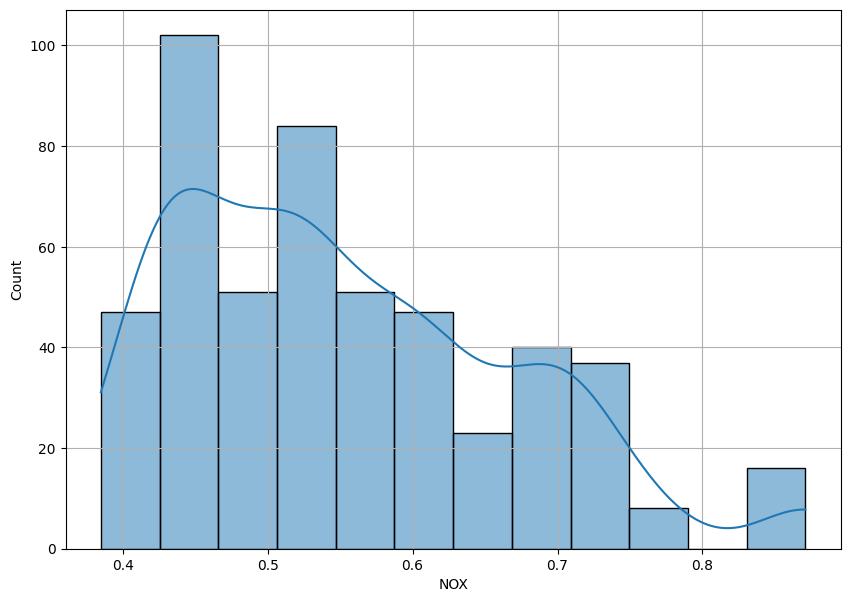

In [23]:
fig, ax = plt.subplots(figsize=(10,7))
sn.histplot(data=boston_df, x=feature_name, ax=ax, kde=True)
plt.grid(True)

Przygotujmy zbiór danych dzieląc dataset na zbiór danych treningowych, walidacyjnych i testowych (proporcja 3-1-1=60%-20%-20%). Na tym etapie będziemy decydować, które cechy będą używane do tworzenia modeli. Lista uwzględnionych cech ustalana jest w liście ```chosen_features```. Aby podejrzeć listę dostępnych cech wystarczy wywołać komendę ```boston_df.columns```.



In [20]:
chosen_features = ['RM', 'LSTAT', 'PTRATIO', 'NOX', 'AGE']
X = boston_df[chosen_features]
Y = boston_df['TARGET']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = RANDOM_SEED, shuffle=True)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size = 0.25, random_state = RANDOM_SEED, shuffle=True)

Modele bedą poddawane ocenie przy pomocy metod klasy ```RegressScoring```. Dostępne są następujące metryki:
- MSE
- MAPE  
- regressor.score

W tym ćwiczeniu będziemy się skupiać w szczególności na MSE.

#### **Zadanie 1a** Wielkość modelu
Skoro znany jest zbiór danych to można przejść do modelowania i analizy zjawiska generalizacji.

Jednym z parametrów, które będą wpływać na ekspresywność modelu jest jego **wielkość** (np liczba warstw w sieci MLP, liczba neuronów w warstwach ukrytych, wysokość modelu drzewiastego itp).  

Pierwszy eksperyment będzie polegać na nauczeniu regresyjnych drzew decyzyjnych (scikit-learn: [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)). Plusem tego typu modelu jest jego prostota i w miarę prosta możliwość analizy. Podstawowym parametrem odpowiadającym za wielkości modelu będzie ```max_depth```, który odpowiada za wysokość drzewa. W poniższych eksperymentach analizowany będzie zakres $max\_depth \in (1,20)$.

Celem ćwiczenia jest rozpoznanie zależności między generalizacją, a wielkością modelu oraz wielkością zbioru danych. Będzie to możliwe dzięki wygenerowaniu tzw. ***krzywej uczenia***. Prezentuje ona zależność między wielkością zbioru uczącego oraz uzyskiwanymi błędami uczenia i walidacji. Rozmiar zbioru treningowego w eksperymentach będzie zmieniał się w zakresie $training\_set\_sizes \in (10:10:300)$. Dla zwiększających się wielkości modelu będzie można przeanalizować dla jakiej wartości następuje utrata generalizacji, spowodowana niedouczeniem lub przeuczeniem.

Przed przystąpieniem do ćwiczenia bardzo proszę o zapoznanie się z rozdziałem *Learning curves* (str 55-64) z książki *Machine Learning Yearning* autorstwa Andrew Ng (podgląd dostępny np [tutaj](https://d2wvfoqc9gyqzf.cloudfront.net/content/uploads/2018/09/Ng-MLY01-13.pdf)).

In [24]:
max_depths = range(1,21)
training_set_sizes = range(10,X_train.shape[0],10)

train_results = np.zeros(shape=(len(training_set_sizes),len(max_depths)))
valid_results = np.zeros(shape=(len(training_set_sizes),len(max_depths)))
for i, depth in enumerate(max_depths):
    for j, train_size in enumerate(training_set_sizes):
        regressor = DecisionTreeRegressor(random_state=RANDOM_SEED, max_depth=depth).fit(X_train.iloc[:train_size,:], Y_train[:train_size])
        train_results[j,i] = RegressScoring.mean_sqr_error(Y_train[:train_size], regressor.predict(X_train.iloc[:train_size,:]))
        valid_results[j,i] = RegressScoring.mean_sqr_error(Y_valid, regressor.predict(X_valid))

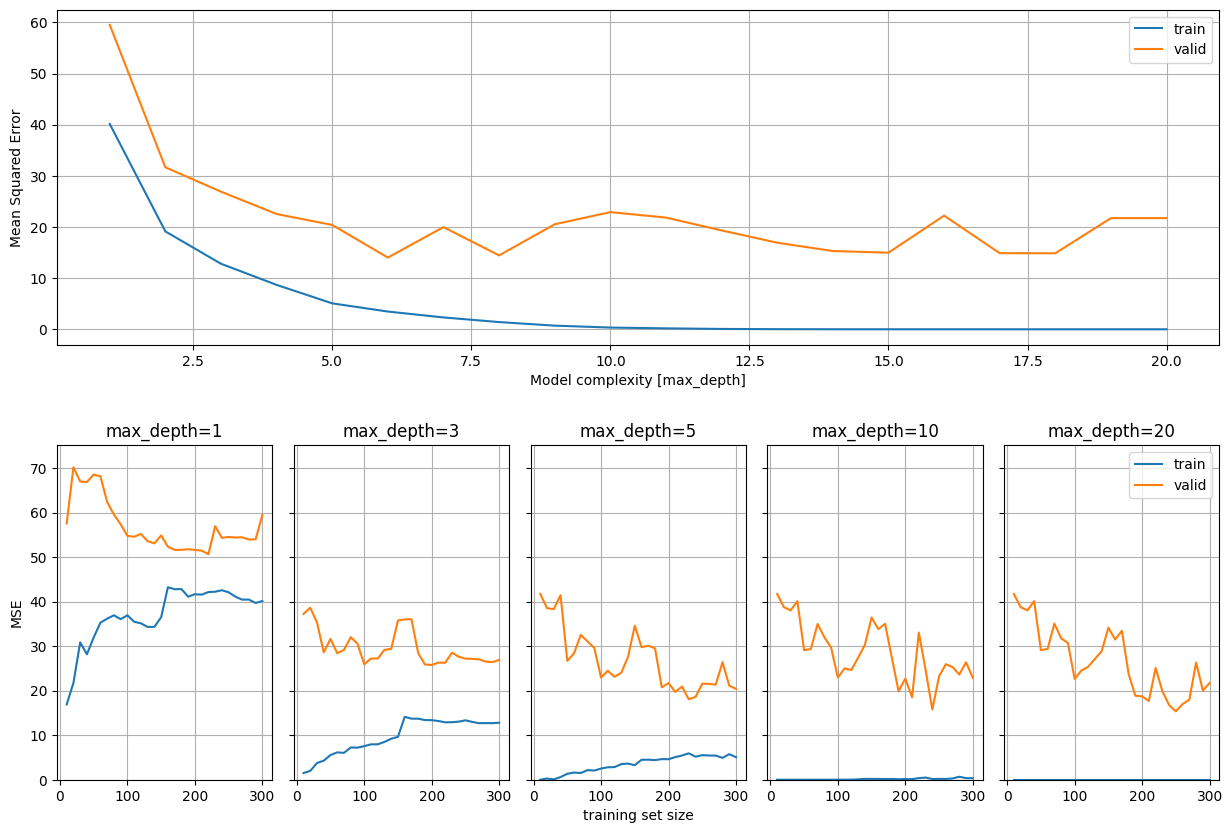

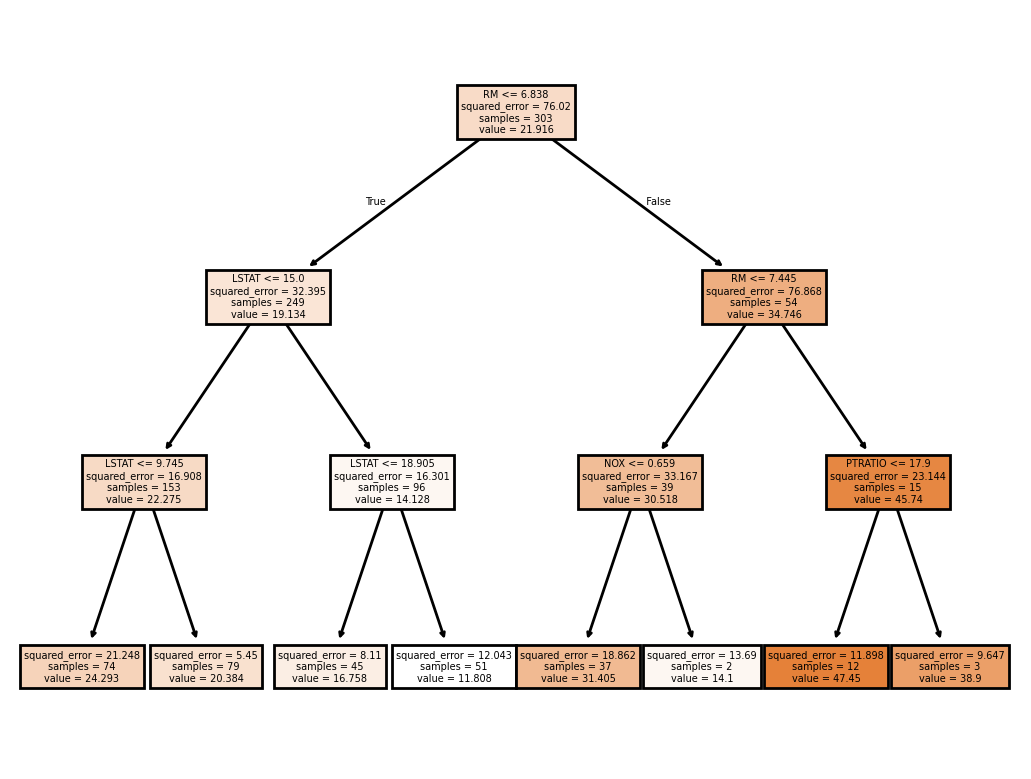

In [25]:
fig = plt.figure(figsize=(15, 10))
outer = gridspec.GridSpec(2, 1, wspace=0.3, hspace=0.3)

axs = plt.Subplot(fig, outer[0])
axs.plot(max_depths, train_results[-1,:], label='train')
axs.plot(max_depths, valid_results[-1,:], label='valid')
axs.grid(True)
axs.legend()
axs.set_xlabel('Model complexity [max_depth]')
axs.set_ylabel('Mean Squared Error')
fig.add_subplot(axs)

inner = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=outer[1], wspace=0.1, hspace=0.1)
axs1 = plt.Subplot(fig, inner[0])
axs1.plot(training_set_sizes, train_results[:,0], label='train')
axs1.plot(training_set_sizes, valid_results[:,0], label='valid')
axs1.grid(True)
axs1.set_title('max_depth=1')
axs1.set_ylabel('MSE')
axs1.set_ylim([0,np.max(valid_results[:,0])+5])
fig.add_subplot(axs1)

axs2 = plt.Subplot(fig, inner[1])
axs2.plot(training_set_sizes, train_results[:,2], label='train')
axs2.plot(training_set_sizes, valid_results[:,2], label='valid')
axs2.grid(True)
axs2.set_title('max_depth=3')
axs2.set_ylim([0,np.max(valid_results[:,0])+5])
axs2.axes.yaxis.set_ticklabels([])
fig.add_subplot(axs2, sharey=axs1)

axs3 = plt.Subplot(fig, inner[2])
axs3.plot(training_set_sizes, train_results[:,4], label='train')
axs3.plot(training_set_sizes, valid_results[:,4], label='valid')
axs3.grid(True)
axs3.set_title('max_depth=5')
axs3.set_xlabel('training set size')
axs3.set_ylim([0,np.max(valid_results[:,0])+5])
axs3.axes.yaxis.set_ticklabels([])
fig.add_subplot(axs3, sharey=axs1)

axs4 = plt.Subplot(fig, inner[3])
axs4.plot(training_set_sizes, train_results[:,9], label='train')
axs4.plot(training_set_sizes, valid_results[:,9], label='valid')
axs4.grid(True)
axs4.set_title('max_depth=10')
axs4.set_ylim([0,np.max(valid_results[:,0])+5])
axs4.axes.yaxis.set_ticklabels([])
fig.add_subplot(axs4, sharey=axs1)

axs5 = plt.Subplot(fig, inner[4])
axs5.plot(training_set_sizes, train_results[:,19], label='train')
axs5.plot(training_set_sizes, valid_results[:,19], label='valid')
axs5.grid(True), axs5.legend()
axs5.set_title('max_depth=20')
axs5.set_ylim([0,np.max(valid_results[:,0])+5])
axs5.axes.yaxis.set_ticklabels([])
fig.add_subplot(axs5, sharey=axs1)

fig.show()

chosen_depth = 3
plt.figure(dpi=200)
regressor = DecisionTreeRegressor(random_state=RANDOM_SEED, max_depth=chosen_depth).fit(X_train, Y_train)
_ = plot_tree(regressor, feature_names=chosen_features, filled=True)
plt.show()



#### **Pytania**

0. Proszę wyjaśnić zjawisko utraty generalizacji oraz wyjaśnić własnymi słowami rozumienie słowa generalizacja.
1. W sprawozdaniu proszę zamieścić uzyskane wykresy uczenia modeli drzewiastych. Proszę opisać i scharakteryzować uzyskane wykresy (osobno górny i dolny rząd).
2. Na przykładzie wykresu górnego proszę wyjaśnić jak zależy błąd treningu i walidacji w zależności od wielkości modelu. Co dzieje się z wykresami błędu gdy wielkość modelu osiąga wystarczająco duże wielkości (~ dąży do nieskończoności)?
3. Na przykładzie wykresów z dolnego rzędu, jakie wyniki osiągają modele uczone na małym podzbiorze danych, a jakie na większym podzbiorze?
4. Korzystając ze wszystkich wykresów proszę która z wartości ```max_depth``` jest optymalna z punktu widzenia treningu i walidacji? Proszę uzasadnić odpowiedź.
5. Dla wybranej wartości ```max_depth``` proszę wytrenować jedno drzewo dla pełnego zbioru danych. Następnie należy podejrzeć strukturę drzewa (reguły decyzyjne) oraz wymienić 2-3 najczęściej wykorzystywane zmienne w węzłach decyzyjnych (rozgałęzieniach). Można w tym celu wykorzystać następujące linie kodu:
```
chosen_depth = #{TUTAJ NALEŻY WPISAĆ WYBRANĄ WARTOŚĆ WYSOKOŚCI DRZEWA}
plt.figure(dpi=200)
regressor = DecisionTreeRegressor(random_state=RANDOM_SEED, max_depth=chosen_depth).fit(X_train, Y_train)
_ = plot_tree(regressor, feature_names=chosen_features, filled=True)
plt.show()
```
6. Jakie zakresy wartości ```max_depth``` odpowiadają modelom przeuczonym, a jakie niedouczonym?
7. Czemu powyższa analiza jest wykonywana na zbiorze danych trenujących i walidujących zamiast trenującym i testującym? Proszę uzasadnić odpowiedź.



#### **Zadanie 1b** Hiperparametry modelu

Drugie ćwiczenie będzie dotyczyć wpływu hiperparametrów modeli na zdolności generlizacyjne na przykładzie sieci SVM z jądrem gaussowskim w zadaniu regresji. Będzie zaprezentowany wpływ wartości $\gamma (gamma)$ na budowane modele, zakres badanych gamm będzie obejmować $\gamma \in (10^{-5}, 10^{5})$. Zbadane zostaną trzy zmienne: błąd walidacji (MSE), liczba wektorów nośnych (ang. *support vector*) oraz gamma. W trakcie uczenia pozostałe hiperparametry pozostaną stałe i równe $C=1000 (regularyzacja), \epsilon=10 (epsilon)$.

In [ ]:
gammas = np.reshape(np.reshape(np.repeat(np.logspace(-5,5,11), 3, axis=0), (11,3))*[1,2,5],(33))
valid_mse = []
num_sv = []

for gamma in gammas:
    regressor = make_pipeline(StandardScaler(), SVR(gamma=gamma, C=1000, epsilon=10))
    regressor.fit(X_train, Y_train)
    valid_mse.append(RegressScoring.mean_sqr_error(Y_valid, regressor.predict(X_valid)))
    num_sv.append(regressor['svr'].n_support_[0])

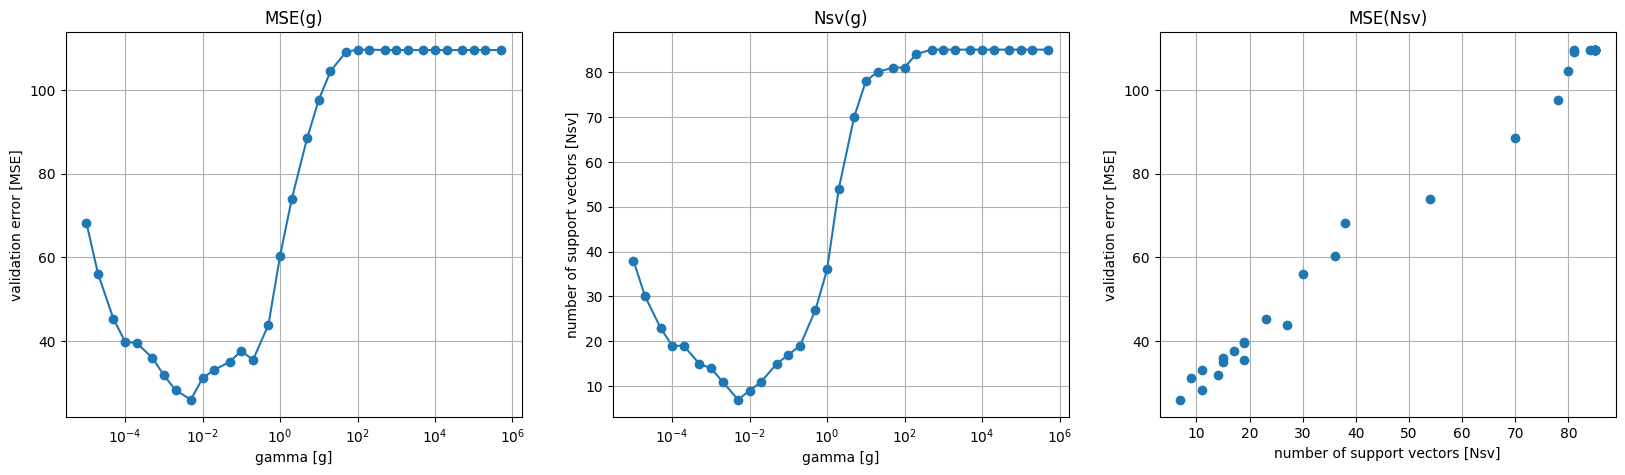

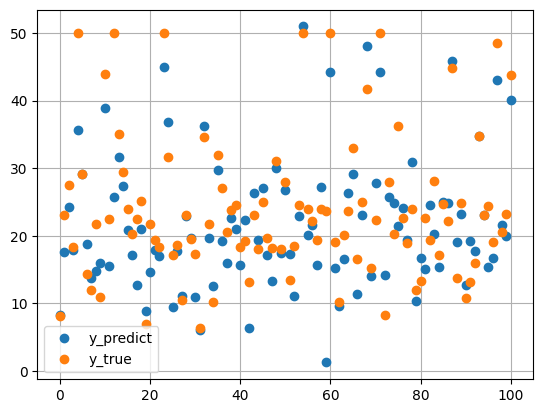

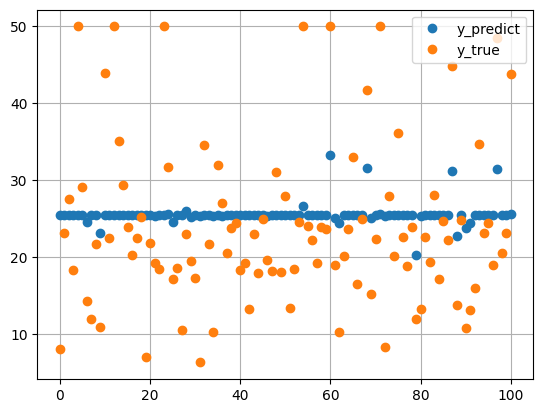

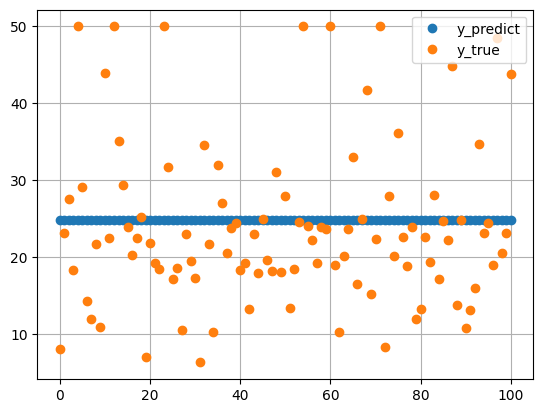

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].plot(gammas, valid_mse, '-o'), ax[0].grid(True), ax[0].set_xscale('log'), ax[0].set_title('MSE(g)'), ax[0].set_xlabel('gamma [g]'), ax[0].set_ylabel('validation error [MSE]')
ax[1].plot(gammas, num_sv, '-o'), ax[1].grid(True), ax[1].set_xscale('log'), ax[1].set_title('Nsv(g)'), ax[1].set_xlabel('gamma [g]'), ax[1].set_ylabel('number of support vectors [Nsv]')
ax[2].plot(num_sv, valid_mse, 'o'), ax[2].grid(True), ax[2].set_title('MSE(Nsv)'), ax[2].set_xlabel('number of support vectors [Nsv]'), ax[2].set_ylabel('validation error [MSE]')
plt.show()

regressor = make_pipeline(StandardScaler(), SVR(gamma=10**-2, C=1000, epsilon=10))  # Set gamma to a large value
regressor.fit(X_train, Y_train)
plt.plot(range(Y_valid.shape[0]), regressor.predict(X_valid), 'o')  # Predict on validation data
plt.plot(range(Y_valid.shape[0]), Y_valid, 'o')  # Plot true validation values
plt.grid(True)
plt.legend(['y_predict','y_true'])
plt.show()


regressor = make_pipeline(StandardScaler(), SVR(gamma=10**1, C=1000, epsilon=10))  # Set gamma to a large value
regressor.fit(X_train, Y_train)
plt.plot(range(Y_valid.shape[0]), regressor.predict(X_valid), 'o')  # Predict on validation data
plt.plot(range(Y_valid.shape[0]), Y_valid, 'o')  # Plot true validation values
plt.grid(True)
plt.legend(['y_predict','y_true'])
plt.show()

regressor = make_pipeline(StandardScaler(), SVR(gamma=10**5, C=1000, epsilon=10))  # Set gamma to a large value
regressor.fit(X_train, Y_train)
plt.plot(range(Y_valid.shape[0]), regressor.predict(X_valid), 'o')  # Predict on validation data
plt.plot(range(Y_valid.shape[0]), Y_valid, 'o')  # Plot true validation values
plt.grid(True)
plt.legend(['y_predict','y_true'])
plt.show()

#### **Pytania**

0. Jaki wpływ ma dobór parametrów $\gamma$ (gamma), $\epsilon$ (epsilon) oraz $C$ (kara) na trening sieci SVM? Proszę udzielić odpowiedzi odnosząc się do procesu trenowania sieci SVM.
1. W sprawozdaniu proszę zamieścić uzyskany wykres zależności zmiennych MSE, Nsv oraz g. Proszę skomentować uzyskane przebiegi.
2. Dla jakiej gammy uzyskuje się model o najlepszych właściwościach generalizacyjnych? Ile wektorów nośnych odpowiada wyborowi tej gammy?
3. W jakim zakresie gamm i liczby wektorów nośnych następuje utrata generalizacji w badanych sieciach SVM?
4. Jak zależy liczba wektorów nośnych od gammy? O czym może świadczyć bardzo duża liczba wektorów nośnych?
5. Jak zależy błąd walidacji od gammy? Czym może być spowodowane wypłaszczenie charakterystyki w zakresie $\gamma>1$? Podpowiedź: Proszę spojrzeć na generowane odpowiedzi sieci dla przypadku np. $\gamma=10^5$. Można posłużyć się poniższym kodem, uzupełniając poszczególne zmienne zaznaczone tekstem TUTAJ:
```
regressor = make_pipeline(StandardScaler(), SVR(gamma=**TUTAJ**, C=1000, epsilon=10))
regressor.fit(X_train, Y_train)
plt.plot(range(Y_valid.shape[0]), regressor.predict(**TUTAJ**), 'o')
plt.plot(range(Y_valid.shape[0]), **TUTAJ**, 'o')
plt.grid(True)
plt.legend(['y_predict','y_true'])
```

### **Zadanie 2** Wizja komputerowa

Drugie ćwiczenie będzie wykorzystywać **zadanie klasyfikacji** obrazów do zobrazowania problematyki generalizacji w sieciach neuronowych. Wykorzystywane będą 2 architektury: **Vanilla Neural Network** i **Convolutional Neural Network**.

#### MNIST dataset

W eksperymentach będzie wykorzystywany zbiór MNIST, czyli jeden z najczęściej wykorzystywanych datasetów z obrazami odręcznie pisanych cyfr 0-9 (10 klas). Zbiór danych jest prosty i w miarę znormalizowany pod względem liczności, wielkości obrazów (28x28px) i ich jakości. Zaczniemy od prostej wizualizacji zbioru danych, w tym wyświetlenia przykładowych obrazów.

In [26]:
batch_size_train = 10
batch_size_test = 1000

In [27]:
train_loader, valid_loader, test_loader = read_MNIST(batch_size_train, batch_size_test, 'zad2a')
classes = tuple([str(i) for i in range(0,10)])

In [28]:
#@title Który zbiór danych należy zwizualizować?
which_dataset = "trenuj\u0105cy" #@param ["trenujący", "walidacyjny", "testujący"]

if which_dataset == 'trenujący':
    visualize_dataset = list(train_loader)
elif which_dataset == 'walidacyjny':
    visualize_dataset = list(valid_loader)
elif which_dataset == 'testujący':
    visualize_dataset = list(test_loader)
else:
    raise

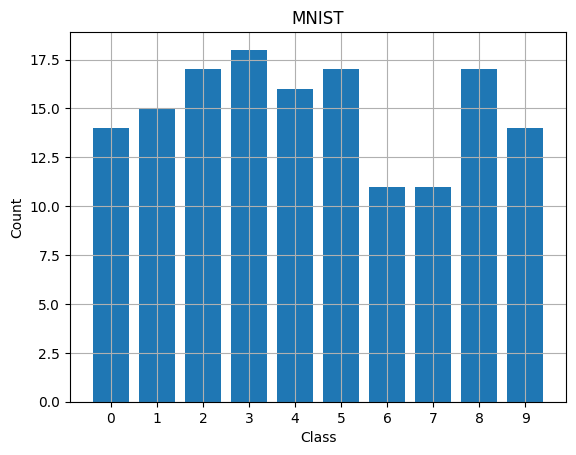

In [29]:
targets = []
[targets.extend(batch[-1]) for batch in visualize_dataset]

keys, counts = np.unique(targets, return_counts=True)
plt.bar(classes, counts)
plt.grid(True)
plt.title('MNIST')
plt.ylabel('Count')
plt.xlabel('Class')
plt.show()

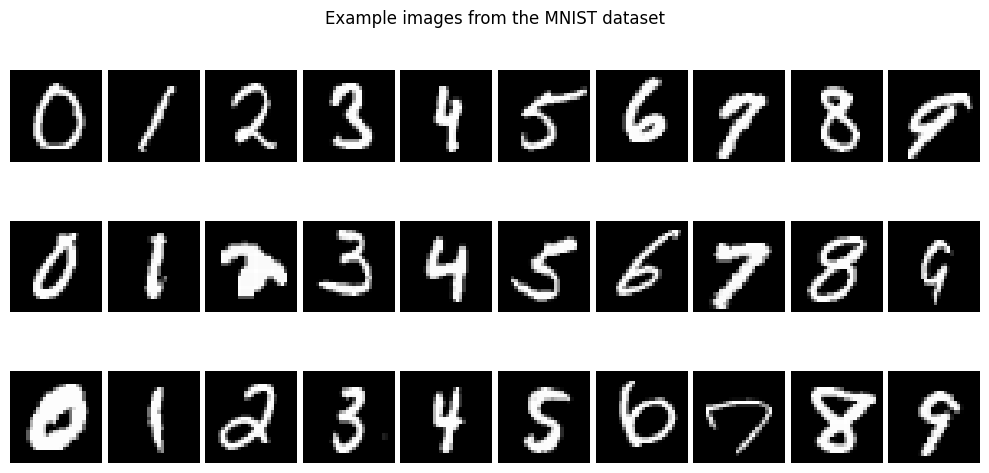

In [30]:
num_examples = 3

fig, ax = plt.subplots(num_examples, 10, figsize=(10,5))
for i in range(0, 10):
    plot = 0
    for batch in visualize_dataset:
        for idx, example in enumerate(batch[-1]):
            if example == i:
                ax[plot, i].imshow(batch[0][idx][0, :, :], cmap=plt.get_cmap('gray'))
                ax[plot, i].axis('off')
                plot += 1
            if plot == num_examples:
                break
        else:
            continue
        break
plt.subplots_adjust(bottom=0.3, top=0.7, wspace=0.025, hspace=0)
plt.suptitle('Example images from the MNIST dataset')
plt.tight_layout()
plt.show()

#### **Zadanie 2a** Generalizacja vs. wielkość modelu

W tym ćwiczeniu skupimy się na zagadnieniu ***bias-variance trade-off***. Ocenę własności generalizacyjnych modeli można przedstawić w postaci oceny dwóch przeciwstawnych sobie członów:
* **bias** (obciążenie) - uproszczenia poczynione przez model podczas treningu, *wyrażane jako różnica założonego poziomu błędu jaki planujemy osiągnąć przez modelowanie i błędu na zbiorze trenującym* (jako założony poziom błędu najczęściej przyjmuje się tzw. *human level* w danym zadaniu, czyli osiągany poziom błędu przez osobę, która mogłaby zastąpić model, *dla zadania rozpoznawania cyfr pisanych ręcznie możemy bez problemu założyć 100% dokładność docelową*),
* **variance** (wariancja) - o ile gorzej radzi sobie model na zbiorze walidacyjnym względem zbioru trenującego, *wyrażany jako prosta różnica obu błędów*.

Zbudowany zostanie prosty model sieci neuronowej przedstawiony w klasie ```VanillaNet```. Jest to prosty perceptron wielowarstwowy z funkcją aktywacji ReLU i wyjściem Softmax. Obrazy na wejściu będą musiały zostać poddane spłaszczeniu, aby dostosować się do formatu wejścia sieci neuronowych (co nie zawsze jest dobrą techniką wektoryzacji, ale w przypadku znormalizowanego zbioru MNIST pozwoli osiągnąć dobre wyniki). W ćwiczeniu ograniczymy zbiór trenujący do raptem kilkunastu przykładów per klasa (10-20 przykładów per cyfra) i będziemy zmieniać rozmiar warstwy ukrytej (liczbę neuronów ukrytych) $hidden\_sizes \in \{2, 3, 5, .. 20, 30\}$. Modele będą uczone w analogiczny sposób (ten sam algorytm, hiperparametry optymalizacji, liczba epok) z wykorzystaniem techniki [EarlyStopping](https://en.wikipedia.org/wiki/Early_stopping) oraz [LearningRateScheduler](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate). Aby zminimalizować efekty losowe podczas uczenia każda konfiguracja sieci będzie uczona 10 krotnie, a wyniki będą uśredniane między próbami.

Celem ćwiczenia jest zaobserwowanie zależności między uproszczeniami modelu (obciążeniem, ang. *bias*), a wariancją (ang. *variance*).

Przed przystąpieniem do ćwiczenia zalecam zapoznanie się z rozdziałem *Bias and Variance* (str 41-54) z książki *Machine Learning Yearning* autorstwa Andrew Ng (podgląd dostępny np [tutaj](https://github.com/ajaymache/machine-learning-yearning/blob/master/full%20book/machine-learning-yearning.pdf)).

In [31]:
NUM_EPOCHS = 10
PATIENCE = 5
NUM_CLASSES = 10
learning_rate = 0.1
momentum = 0.9

In [34]:
hidden_sizes = [2,3,5,8,12,15,20,30]

train_errs = []
valid_errs = []
test_errs = []

for model_size in hidden_sizes:
    mean_train = []
    mean_valid = []
    mean_test = []
    for i in range(10):
        model = VanillaNet(model_size)
        model = model.to(DEVICE)
        optimizer = optim.SGD(model.parameters(),
                              lr=learning_rate,
                              momentum=momentum)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

        model, train_loss, valid_loss, train_loss_per_batch, valid_loss_per_batch, train_errors, valid_errors = train_model(model)
        predictions_total, targets_total, test_err = test_model(model)
        mean_train.append(train_errors[-1])
        mean_valid.append(valid_errors[-1])
        mean_test.append(test_err)

    train_errs.append(np.mean(mean_train))
    valid_errs.append(np.mean(mean_valid))
    test_errs.append(np.mean(mean_test))

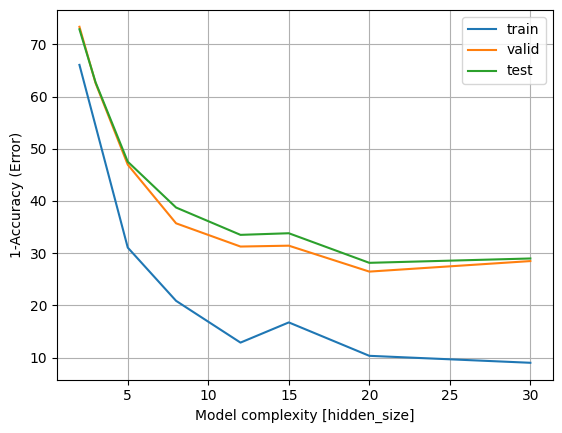

In [35]:
plt.plot(hidden_sizes, train_errs)
plt.plot(hidden_sizes, valid_errs)
plt.plot(hidden_sizes, test_errs)
plt.xlabel('Model complexity [hidden_size]')
plt.ylabel('1-Accuracy (Error)')
plt.grid(True)
plt.legend(['train', 'valid', 'test'])
plt.show()

#### **Pytania**
0. Czym jest niedouczenie modelu w kontekście bias-variance tradeoff (ang. *avoidable bias*)? Jakie techniki mogą zostać użyte aby zminimalizować jego wpływ na trenowany model?
1. Jakie techniki poprawiają uwarunkowanie uczenia, aby docelowo stworzyć model o niższej wariancji?
2. W sprawozdaniu proszę zamieścić wykres przedstawiający błąd w funkcji wielkości modelu. Proszę skomentować widoczne charakterystyki. *Jeżeli obserwujemy taką zależność:* Czy niższy błąd na zbiorze testowym od zbioru walidacyjnego jest typowym i oczekiwanym efektem w uczeniu sieci neuronowych?
2. W komórce kodu poniżej proszę uzupełnić wyrażenie na zmienne ```bias``` oraz ```variance```. Potrzebne będą do tego zmienne ```train_errs``` oraz ```valid_errs```. Następnie wyświetlić wykres przedstawiający przebieg tych zmiennych w funkcji wielkości modelu. Proszę opisać i skomentować uzyskane wykresy. Czy na podstawie tego wykresu można określić optymalny rozmiar modelu?


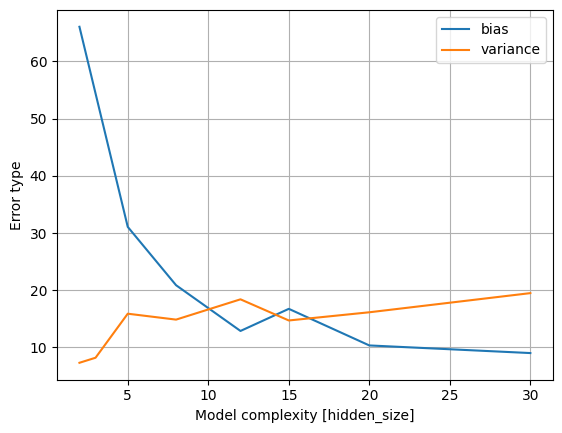

In [37]:
bias = train_errs
variance = [v - t for v, t in zip(valid_errs, train_errs)]

plt.plot(hidden_sizes, bias)
plt.plot(hidden_sizes, variance)
plt.xlabel('Model complexity [hidden_size]')
plt.ylabel('Error type')
plt.grid(True)
plt.legend(['bias', 'variance'])
plt.show()

#### **Zadanie 2b** Generalizacja vs. ekspresywność modelu i uwarunkowanie procesu uczenia

Ćwiczenie zaprezentuje porównanie między dwoma konkurencyjnymi modelami klasyfikacji obrazów:
- prostym modelem perceptronu wielowarstwowego MLP (modelem z ćwiczenia 2a),
- płytką siecią konwolucyjną.

Modele różnią się [ekspresywnością](https://blog.evjang.com/2017/11/exp-train-gen.html). W kontekście generalizacji, **model bardziej ekspresywny** będzie **przy mniejszej liczbie neuronów osiągać lepsze zdolności generalizacyjne** (lepiej modelować dane zagadnienie z mniejszymi błędami testowania) lub przy tej samej liczbie parametrów będzie **potrafił modelować bardziej skomplikowane funkcje** . Podobnie jak w zadaniu 2a zastosujemy dokładnie identyczne warunki treningu, tym razem z większą porcją danych uczących (500 batchy po 64 przykłady). Badania będą obejmować najbardziej popularne techniki wizualizacji wyników osiąganych na zbiorze testującym w zadaniach klasyfikacji:
- logi treningu w postaci osiąganej funkcji kosztu oraz dokładności (accuracy),
- wykres funkcji kosztu osiąganej w kolejnych epokach i batchach uczenia (dla zbioru treningowego i walidacyjnego),
- wykres dokładności treningu i walidacji per epoka uczenia,
- wyniki funkcji kosztu, dokładności i precyzji per klasa na zbiorze testującym,
- numeryczne zestawienie podstawowych uśrednionych metryk klasyfikacji (dokładność ACC, precyzja PREC, czułość REC, miara F1,
- raport klasyfikacji (ang. *classification report*) zawierający zestawienie podstawowych metryk per klasa
- macierz pomyłek (ang. *confusion matrix*)
- przykładowe predykcje na zbiorze testującym (na jednym batchu danych testujących = u nas 64 przykłady)

In [38]:
batch_size_train = 64
batch_size_test = 64

train_loader, valid_loader, test_loader = read_MNIST(batch_size_train, batch_size_test, 'zad2b')

In [39]:
NUM_EPOCHS = 20
PATIENCE = 2
NUM_CLASSES = 10
learning_rate = 0.05
momentum = 0.5
hidden_size = 50

##### Vanilla Neural Network

In [40]:
model = VanillaNet(hidden_size)
model = model.to(DEVICE)

optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate,
                      momentum=momentum)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [41]:
valid_errors = [100]
while(valid_errors[-1]>10):
    model, train_loss, valid_loss, train_loss_per_batch, valid_loss_per_batch, train_errors, valid_errors = train_model(model, verbose=True)

[ 1/20] | train_loss: 1.71056 valid_loss: 1.57821 | train_acc: 80.80% valid_acc: 90.08%
Validation loss decreased (inf --> 1.578210).  Saving model ...
[ 2/20] | train_loss: 1.56515 valid_loss: 1.55882 | train_acc: 91.10% valid_acc: 91.33%
Validation loss decreased (1.578210 --> 1.558815).  Saving model ...
[ 3/20] | train_loss: 1.54904 valid_loss: 1.54931 | train_acc: 92.20% valid_acc: 92.04%
Validation loss decreased (1.558815 --> 1.549311).  Saving model ...
[ 4/20] | train_loss: 1.53906 valid_loss: 1.54173 | train_acc: 93.08% valid_acc: 92.66%
Validation loss decreased (1.549311 --> 1.541735).  Saving model ...
[ 5/20] | train_loss: 1.53155 valid_loss: 1.53655 | train_acc: 93.84% valid_acc: 93.12%
Validation loss decreased (1.541735 --> 1.536552).  Saving model ...
[ 6/20] | train_loss: 1.52592 valid_loss: 1.53270 | train_acc: 94.36% valid_acc: 93.48%
Validation loss decreased (1.536552 --> 1.532696).  Saving model ...
[ 7/20] | train_loss: 1.52142 valid_loss: 1.52943 | train_acc: 

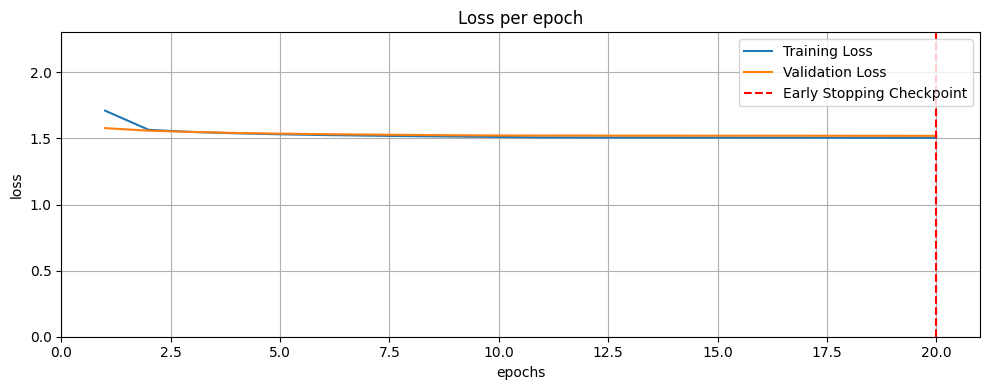

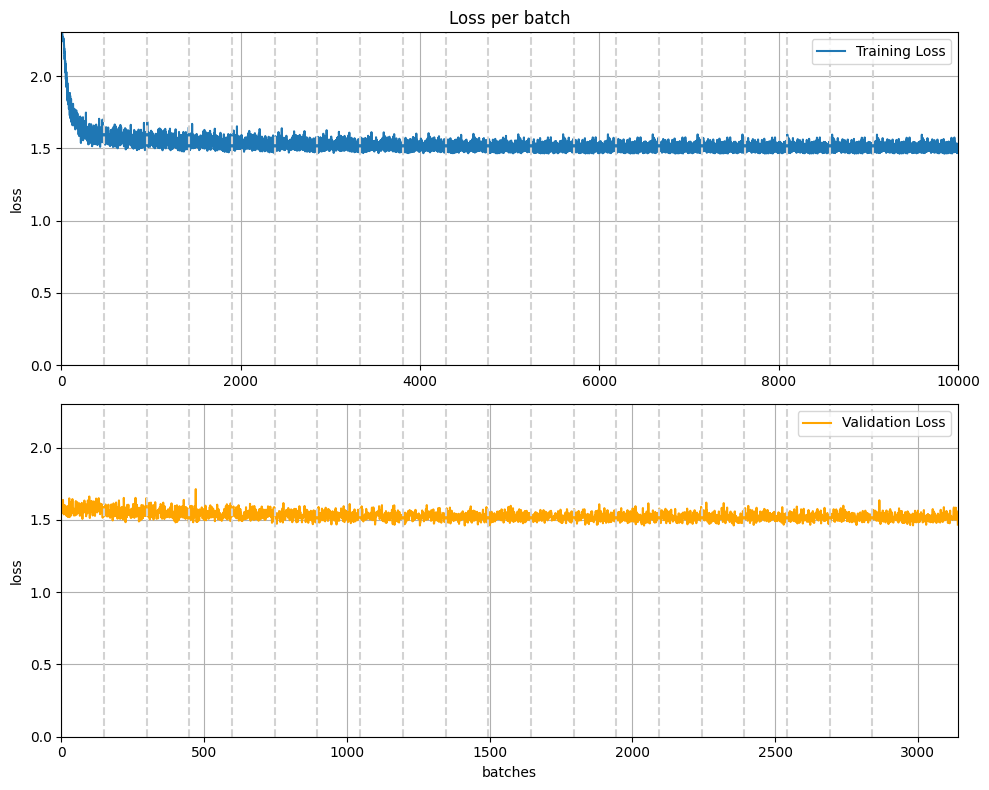

In [42]:
plot_learning_curves(train_loss, valid_loss, train_loss_per_batch, valid_loss_per_batch)

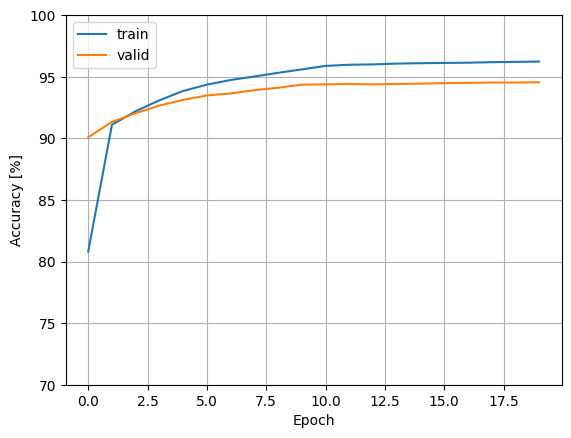

In [43]:
plt.plot(100-np.array(train_errors))
plt.plot(100-np.array(valid_errors))
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.grid(True)
plt.legend(['train', 'valid'])
plt.ylim([70,100])
plt.show()

In [44]:
predictions_total, targets_total, test_err = test_model(model, verbose=True)

Test Loss: 1.512772

Test precision of 0:   98% (964/979)
Test precision of 1:   98% (1115/1134)
Test precision of 2:   94% (973/1031)
Test precision of 3:   93% (948/1009)
Test precision of 4:   95% (938/980)
Test precision of 5:   92% (827/890)
Test precision of 6:   95% (917/957)
Test precision of 7:   94% (971/1026)
Test precision of 8:   92% (897/970)
Test precision of 9:   92% (937/1008)

Test Accuracy (Overall): 95% (9487/9984)


===== TESTING RESULTS =====


,ACC,PREC,REC,F1
0,0.95022,0.950172,0.95022,0.950146



===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       979
           1       0.98      0.98      0.98      1134
           2       0.95      0.94      0.95      1031
           3       0.94      0.94      0.94      1009
           4       0.95      0.96      0.95       980
           5       0.94      0.93      0.94       890
           6       0.95      0.96      0.95       957
           7       0.95      0.95      0.95      1026
           8       0.95      0.92      0.94       970
           9       0.94      0.93      0.94      1008

    accuracy                           0.95      9984
   macro avg       0.95      0.95      0.95      9984
weighted avg       0.95      0.95      0.95      9984



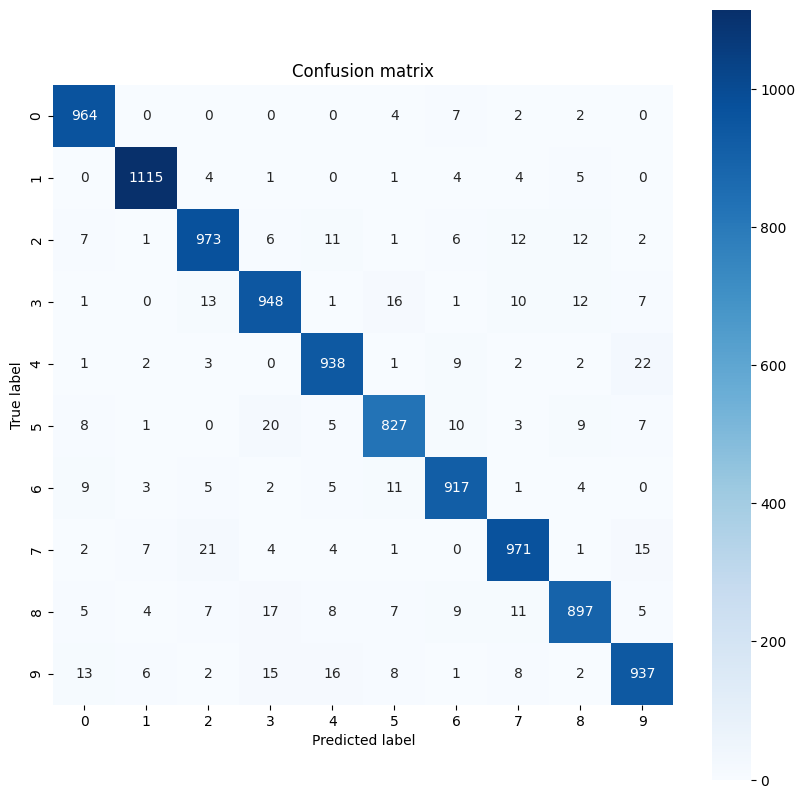

In [45]:
scoring = ClassifyScoring(y_true=targets_total, y_pred=predictions_total, target_names=classes, verbose = True)
_ = scoring.score()
print()
scoring.print_report()
cm_vanilla = scoring.conf_mat()

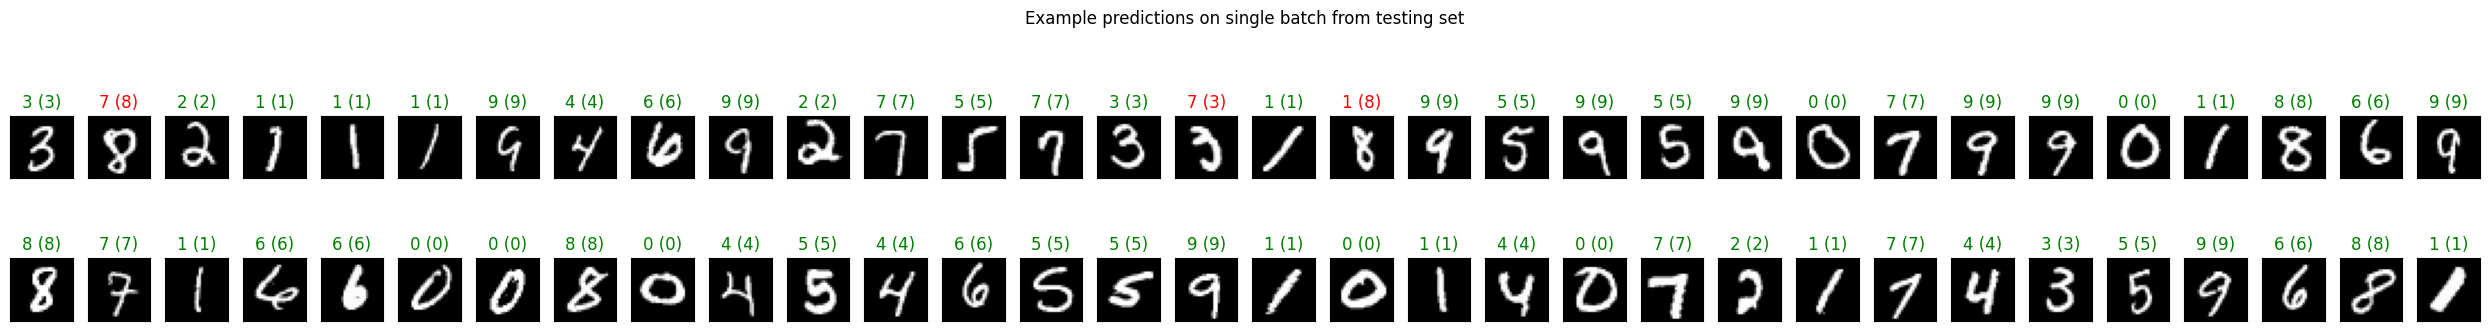

In [48]:
show_example_predictions(model)

##### Convolutional Neural Network

In [49]:
model = ConvNet(hidden_size)
model = model.to(DEVICE)

optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate,
                      momentum=momentum)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [50]:
valid_errors = [100]
while(valid_errors[-1]>10):
    model, train_loss, valid_loss, train_loss_per_batch, valid_loss_per_batch, train_errors, valid_errors = train_model(model, verbose=True)

[ 1/20] | train_loss: 0.68986 valid_loss: 0.14317 | train_acc: 77.43% valid_acc: 95.66%
Validation loss decreased (inf --> 0.143173).  Saving model ...
[ 2/20] | train_loss: 0.31631 valid_loss: 0.10956 | train_acc: 90.48% valid_acc: 96.74%
Validation loss decreased (0.143173 --> 0.109559).  Saving model ...
[ 3/20] | train_loss: 0.25479 valid_loss: 0.08888 | train_acc: 92.45% valid_acc: 97.25%
Validation loss decreased (0.109559 --> 0.088876).  Saving model ...
[ 4/20] | train_loss: 0.23190 valid_loss: 0.08065 | train_acc: 93.15% valid_acc: 97.50%
Validation loss decreased (0.088876 --> 0.080651).  Saving model ...
[ 5/20] | train_loss: 0.20998 valid_loss: 0.07389 | train_acc: 94.00% valid_acc: 97.68%
Validation loss decreased (0.080651 --> 0.073886).  Saving model ...
[ 6/20] | train_loss: 0.19530 valid_loss: 0.06339 | train_acc: 94.27% valid_acc: 98.06%
Validation loss decreased (0.073886 --> 0.063388).  Saving model ...
[ 7/20] | train_loss: 0.18739 valid_loss: 0.06520 | train_acc: 

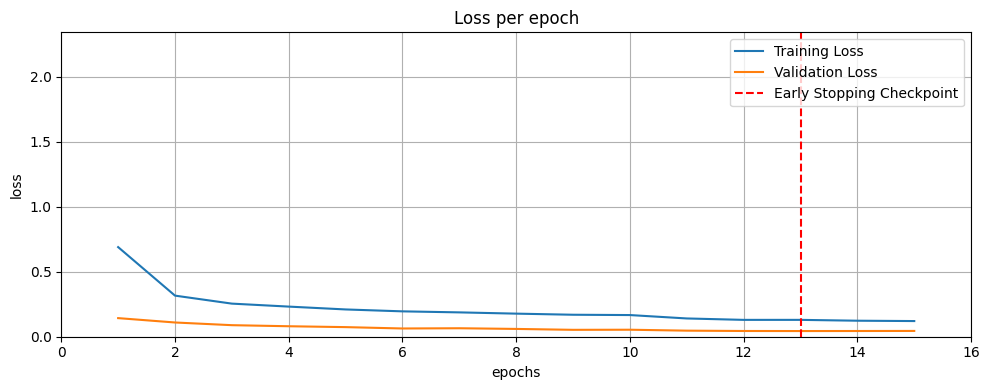

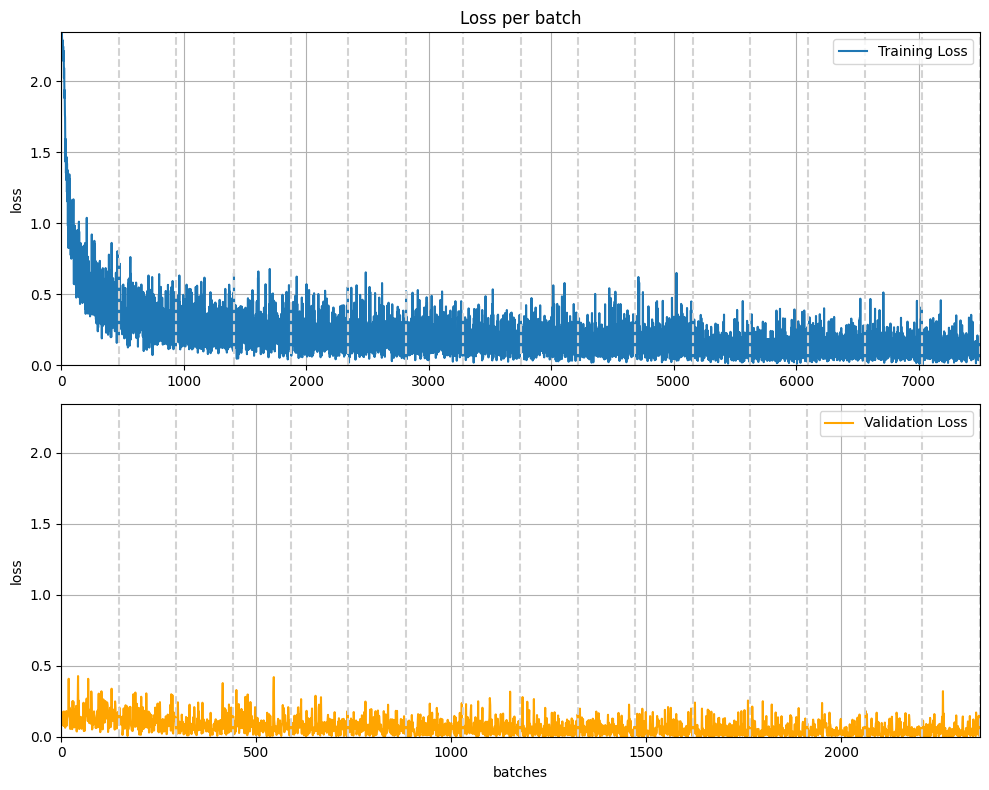

In [51]:
plot_learning_curves(train_loss, valid_loss, train_loss_per_batch, valid_loss_per_batch)

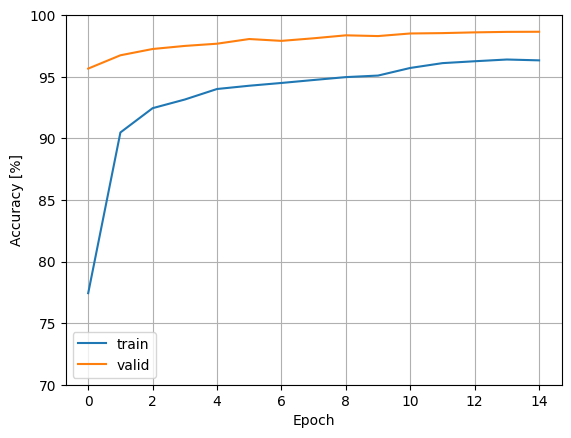

In [52]:
plt.plot(100-np.array(train_errors))
plt.plot(100-np.array(valid_errors))
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.grid(True)
plt.legend(['train', 'valid'])
plt.ylim([70,100])
plt.show()

In [53]:
predictions_total, targets_total, test_err = test_model(model, verbose=True)

Test Loss: 0.042553

Test precision of 0:   99% (976/979)
Test precision of 1:   99% (1128/1133)
Test precision of 2:   98% (1021/1032)
Test precision of 3:   98% (995/1007)
Test precision of 4:   99% (973/980)
Test precision of 5:   98% (880/892)
Test precision of 6:   98% (943/955)
Test precision of 7:   98% (1007/1027)
Test precision of 8:   97% (945/971)
Test precision of 9:   97% (984/1008)

Test Accuracy (Overall): 98% (9852/9984)


===== TESTING RESULTS =====


,ACC,PREC,REC,F1
0,0.986779,0.986798,0.986779,0.986768



===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       979
           1       0.99      1.00      0.99      1133
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.99      1007
           4       0.99      0.99      0.99       980
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       955
           7       0.98      0.98      0.98      1027
           8       0.99      0.97      0.98       971
           9       0.98      0.98      0.98      1008

    accuracy                           0.99      9984
   macro avg       0.99      0.99      0.99      9984
weighted avg       0.99      0.99      0.99      9984



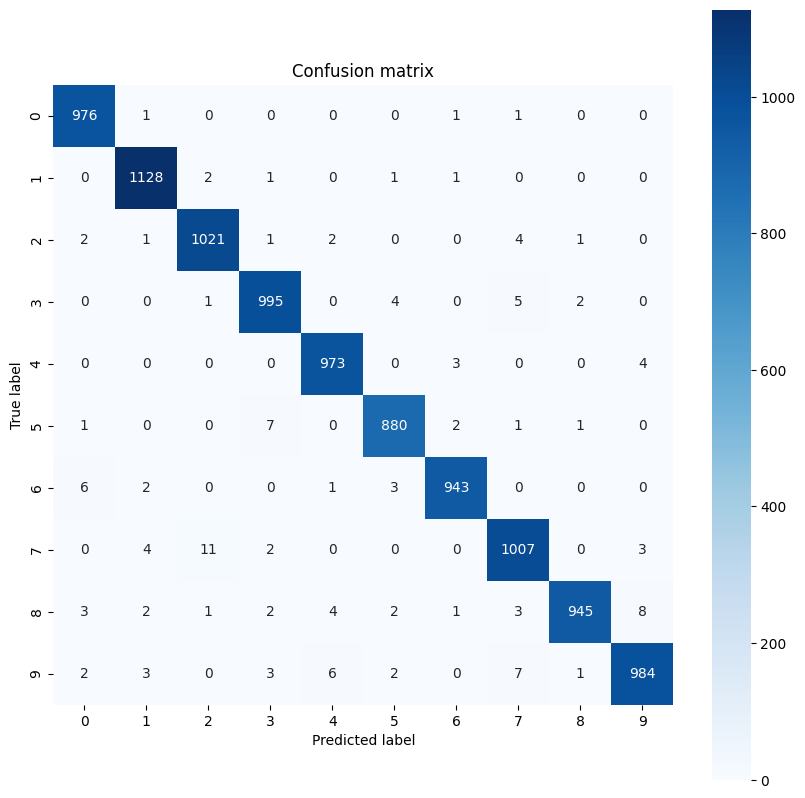

In [54]:
scoring = ClassifyScoring(y_true=targets_total, y_pred=predictions_total, target_names=classes, verbose=True)
_ = scoring.score()
print()
scoring.print_report()
cm_conv = scoring.conf_mat()

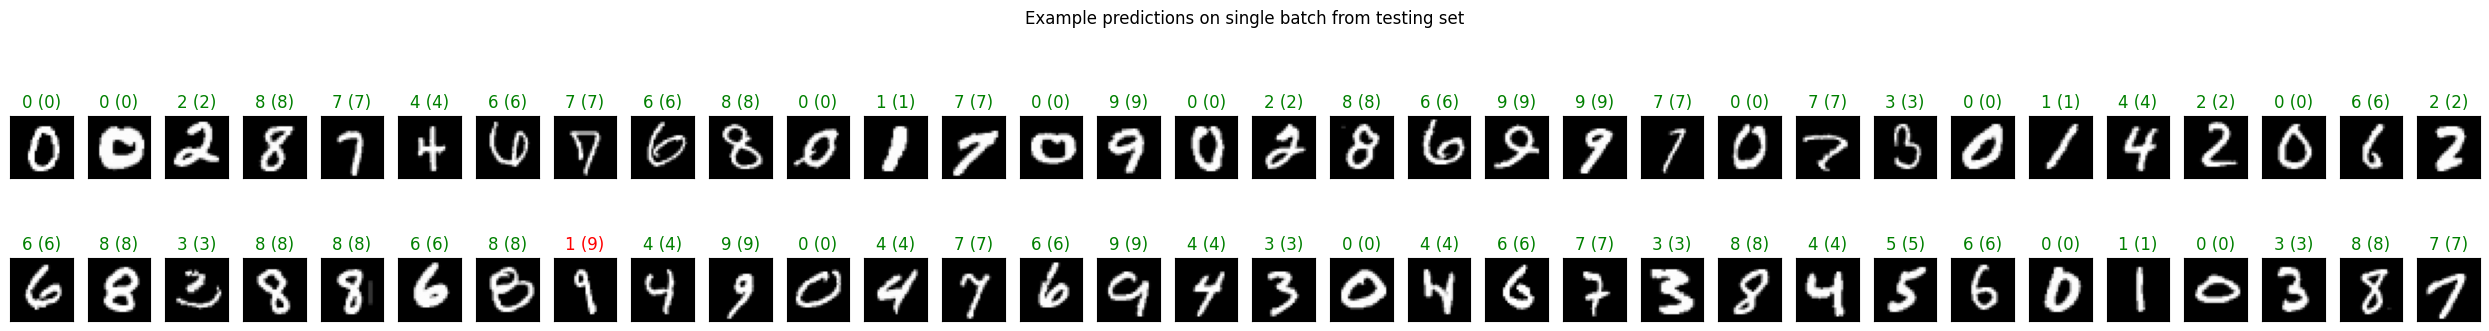

In [55]:
show_example_predictions(model)

#### **Pytania**

0. Proszę własnymi słowami wyjaśnić pojęcie ekspresywności w ujęciu modeli neuronowych.
1. W sprawozdaniu proszę podsumować eksperymenty porównujące VanillaNet i ConvNet (w formie tekstu i zbiorczych tabel i wykresów). Proszę zadbać o zwięzłą prezentację generowanych wykresów, tabeli, raportów, aby nawiązywały do napisanej analizy wyników.
2. Jaka funkcja kosztu była używana podczas treningu sieci? Jaka jest formuła matematyczna tej funkcji?
3. Ile trenowalnych parametrów znajduje się w sieci VanillaNet vs. ConvNet? Który z modeli jest bardziej ekspresywny? Czy dla tego modelu jednocześnie osiągana jest lepsza generalizacja przy mniejszej liczbie parametrów?  
Aby uzyskać liczbę parametrów można skorzystać z poniższej funkcji ```get_n_params```.
```
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
```
4. Czym różnią się macierze pomyłek (ang. *confusion matrix*) uzyskane w treningu sieci VanillaNet (```cm_vanilla```) i ConvNet (```cm_conv```)? Proszę uzupełnić poniższą komórkę kodu i skomentować uzyskane wyniki (przy uzupełnianiu kodu proszę zwrócić uwagę aby poprawnie zdefiniować różnicę tak, aby kolorowanie heatmapy się zgadzało).
5. **Dla chętnych:** Proszę spojrzeć na budowę warstwową modeli VanillaNet oraz ConvNet. Można albo spojrzeć do klas VanillaNet i ConvNet w sekcji Dodatkowe funkcje, albo wyświetlić sobie budowę warstwową klas PyTorcha z pomocą komendy `print(model)`, gdzie model to obiekt klas VanillaNet lub ConvNet. Biorąc pod uwagę używaną funkcję celu, która warstwa w którym modelu jest zbędna? Proszę przeprowadzić dodatkowy eksperyment ewaluacji sieci po wprowadzeniu poprawki i porównać wyniki modelu.

In [ ]:
diff_cm = #{TUTAJ NALEŻY WPISAĆ FORMUŁĘ NA RÓŻNICĘ MACIERZY POMYŁEK}

fig = plt.figure(figsize=(10,10))
sn.heatmap(diff_cm, annot=True, square=True, fmt='g', cmap='RdYlGn', vmin=-20, vmax=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### \* **Zadanie 3** Przetwarzanie języka naturalnego \* - dla chętnych

Ostatnie ćwiczenie dla chętnych obejmuje zagadnienie klasyfikacji tekstu. Tekst z natury nie ma reprezentacji numerycznej (istnieje jedynie dyskretna forma zapisu literowego), co stanowi naczelny problem w zagadnieniach przetwarzania języka naturalnego (żartobliwie mówi się, że *komputer lubi liczby*). Z tego powodu przez ostatnie lata naukowcy wypracowywali metody pozwalające na numeryczną reprezentacji tekstu (np. słowa/zdania/dokumentu) w postaci wektora. Przebadane zostaną 3 niezależne metody wektoryzacji tekstu:
- **Bag-of-words** - najprostszy model wektoryzacji zakładający wektory o wartościach 0-1, o długości słownika wszystkich unikalnych wyrazów, gdzie 1 odpowiada obecności słowa ze słownika w wektoryzowanym tekście,
- **Tf-idf** - ulepszony model wektoryzacji, w którym uwzględniany jest współczynnik związku z wektoryzowanym tekstem (korzysta się z iloczynu częstotliwości występowania słowa w danym dokumencie i częstotliwości występowania w innych dokumentach),
- **Universal Sentence Encoder (USE)** - neuronowy, głęboki model językowy pozwalający na reprezentację tekstu (zazwyczaj zdań) w postaci wysokowymiarowego wektora (ang. *embedding*). Uwzględnia znaczenie semantyczne wyrazów.

Zainteresowanym czytelnikom pozostwiam linki prezentujące więcej szczegółów na temat wybranych metod:  
- [Bag of words i TFIDF](https://www.analyticsvidhya.com/blog/2020/02/quick-introduction-bag-of-words-bow-tf-idf/)  
- [USE](https://amitness.com/2020/06/universal-sentence-encoder/)   
- [embedding - idea](https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture)  
- [embeddingi - modele językowe](https://lilianweng.github.io/lil-log/2017/10/15/learning-word-embedding.html)  
- [o problemie reprezentacji tekstu](https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/)  

Celem ćwiczenia będzie prezentacja zależności między metodą wektoryzacji tekstu (która będzie modelować stopień zaawansowania cech), a zdolnościami generalizacyjnymi.

#### 20NewsGroup dataset

W ćwiczeniu będziemy budować modele klasyfikacji z użyciem danych ze zbioru 20NewsGroup (więcej o tym zbiorze danych można poczytać np. [tutaj](https://kdd.ics.uci.edu/databases/20newsgroups/20newsgroups.html)).

Analogicznie do poprzednich ćwiczeń rozpoczniemy od eksploracji zbioru danych.

**Kategorie 20NewsGroup**

Zbiór 20NewsGroup to dataset złożony z 20000 wiadomości pochodzących z 20 grup tematycznych. Poniżej przedstawiono tytuły 20 kategorii dostępnych w zbiorze danych:

```
* alt.atheism
* comp.graphics
* comp.os.ms-windows.misc
* comp.sys.ibm.pc.hardware
* comp.sys.mac.hardware
* comp.windows.x
* misc.forsale
* rec.autos
* rec.motorcycles
* rec.sport.baseball
* rec.sport.hockey
* sci.crypt
* sci.electronics
* sci.med
* sci.space
* soc.religion.christian
* talk.politics.guns
* talk.politics.mideast
* talk.politics.misc
* talk.religion.misc
```

Na potrzeby ćwiczenia zostały wybrane 4 kategorie krzyżujące się tematycznie (2 z grupy religii i technologii):
```
* alt.atheism
* soc.religion.christian
* comp.os.ms-windows.misc
* comp.sys.ibm.pc.hardware
```

In [ ]:
categories = ['alt.atheism', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'soc.religion.christian']
newsgroup_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=RANDOM_SEED)
newsgroup_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
#@title Który zbiór danych należy zwizualizować?
which_dataset = "testuj\u0105cy" #@param ["trenujący", "testujący"]

if which_dataset == 'trenujący':
    visualize_dataset = newsgroup_train
elif which_dataset == 'testujący':
    visualize_dataset = newsgroup_test
else:
    raise

In [ ]:
keys, counts = np.unique(visualize_dataset.target, return_counts=True)
plt.bar(categories, counts)
plt.grid(True)
plt.xticks(range(len(categories)), categories, rotation='vertical')
plt.title('20NewsGroup')
plt.ylabel('Count')
plt.xlabel('Class')
plt.show()

In [ ]:
print('RAW DATASET')

for category in range(len(categories)):
    for idx, target in enumerate(newsgroup_train.target):
        if target == category:
            print('='*50)
            print(categories[category])
            print('='*50)
            print(newsgroup_train.data[idx])
            break

Na podstawie powyższych przykładów można zauważyć, że teksty mają stosunkowo podobną kontrukcję (podobną do maili/postów) i zawierają stosunkowo dużo nieistotnych dla modelowanych kategorii słów/wyrażeń np. adresy email, specyficzne formatowanie (dla cytowań), podpisy. Aby pozbyć się tych artefaktów należy przeprowadzić tzw. "czyszczenie" zbioru danych. Dla 20NewsGroup zaproponowano następujące kroki, które implementuje klasa Clean20NewsGroup:

- [x] usunąć z tekstu znaki nowej linii \n
- [x] usunąć z tekstu linie zaczynające się np. na From:, Subject:, ...  
- [x] usunąć nadmiarowe puste linie z przodu i tyłu  
- [x] usunąć bardzo częste dla języka słowa (ang. *stopwords*, przykłady ['i', 'you', 'the'])
- [x] usunąć duplikujące się spacje wewnątrz tekstu
- [x] usunąć znaki specjalne
- [x] zmniejszyć litery do małych (ang. *lowercase*)

W komórkach poniżej następuje czyszczenie zbioru oraz wyświetlenie przykładowego wyczyszczonego tekstu.

In [ ]:
cleaned_train = Clean20NewsGroup.clean_20newsgroup(newsgroup_train.data)
cleaned_test = Clean20NewsGroup.clean_20newsgroup(newsgroup_test.data)

In [ ]:
print('CLEANED DATASET')

for category in range(len(categories)):
    for idx, target in enumerate(newsgroup_train.target):
        if target == category:
            print('='*50)
            print(categories[category])
            print('='*50)
            print(cleaned_train[idx])
            break

#### **Zadanie 3** Generalizacja vs. jakość ekstraktora cech

Jakość ekstraktora cech będzie symulowana przez 3 w różnym stopniu skomplikowane algorytmy wektoryzacji tekstu oznaczane w kodzie skrótami ```bow```, ```tfidf``` oraz ```use```. Modele BOW i TFIDF będą połączone z naiwnym klasyfikatorem Bayesa (ze względu na dyskretną, rzadką strukturę generowanych wektorów), a USE z klasyfikaotrem SVM z jądrem gaussowskim. Porównywane będą klasyczne miary jakości klasyfikacji takie jak zestawienie uśrednionych między klasami metryk, wyniki metryk per klasa oraz macierz pomyłek (ang. *confusion matrix*).

##### BAG OF WORDS

In [ ]:
bow_clf = Pipeline([
    ('bow', CountVectorizer()),
    ('clf', MultinomialNB()),
])

bow_clf.fit(cleaned_train, newsgroup_train.target)
predictions = bow_clf.predict(cleaned_test)

In [ ]:
scoring = ClassifyScoring(y_true=newsgroup_test.target, y_pred=predictions, target_names=categories, verbose=False)
results_bow = scoring.score()
scoring.print_report()
cm_bow = scoring.conf_mat()

##### TFIDF

In [ ]:
tfidf_clf = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
tfidf_clf.fit(cleaned_train, newsgroup_train.target)
predictions = tfidf_clf.predict(cleaned_test)

In [ ]:
scoring = ClassifyScoring(y_true=newsgroup_test.target, y_pred=predictions, target_names=categories, verbose=False)
results_tfidf = scoring.score()
scoring.print_report()
cm_tfidf = scoring.conf_mat()

##### USE

In [ ]:
use_clf = Pipeline([
    ('use', USEEmbeddingVectorizer()),
    ('clf', SVC(gamma=1, C=1000)),
])
use_clf.fit(cleaned_train, newsgroup_train.target)
predictions = use_clf.predict(cleaned_test)

In [ ]:
scoring = ClassifyScoring(y_true=newsgroup_test.target, y_pred=predictions, target_names=categories, verbose=False)
results_use = scoring.score()
scoring.print_report()
cm_use = scoring.conf_mat()

##### PORÓWANIE

In [ ]:
results_df = pd.DataFrame([results_bow, results_tfidf, results_use], columns=['ACC', 'PREC', 'REC', 'F1'])
results_df['experiment'] = ['BOW', 'TFIDF', 'USE']
display(results_df[['experiment', 'ACC', 'PREC', 'REC', 'F1']])

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(10,10))
vmax = np.max([cm_bow, cm_tfidf, cm_use])

sn.heatmap(cm_bow, vmin=0, vmax=vmax, annot=True, fmt='g', cmap='Blues', square=True, xticklabels=categories, yticklabels=categories, ax=axs[0], cbar=False)
axs[0].set_title('Bag of words')
axs[0].set_xlabel('Predicted label')
axs[0].set_ylabel('True label')
sn.heatmap(cm_tfidf, vmin=0, vmax=vmax, annot=True, fmt='g', cmap='Blues', square=True, xticklabels=categories, yticklabels=categories, ax=axs[1], cbar=False)
axs[1].set_title('TF-IDF')
axs[1].set_xlabel('Predicted label')
axs[1].set_yticks([])
sn.heatmap(cm_use, vmin=0, vmax=vmax, annot=True, fmt='g', cmap='Blues', square=True, xticklabels=categories, yticklabels=categories, ax=axs[2], cbar=False)
axs[2].set_title('Universal Sentence Encoder')
axs[2].set_xlabel('Predicted label')
axs[2].set_yticks([])
plt.show()

##### **Przykładowe dodatkowe eksperymenty do zadania 3**:

- sprawdzenie jakie przykłady z bazy danych testujących zmieniają oznaczenie klasy dla różnych metod wektoryzacji
- przebadanie wpływu wyboru klasyfikatora na rozwiązanie problemu klasyfikacji 4 klas (wystarczy podmienić obiekt ```'clf'``` w konkretnych Pipeline'ach
- jaki klasyfikator dołączony do USE da najlepsze możliwe wyniki w zadaniu klasyfikacji 4 klasowej? Aby przeprowadzić eksperymenty można potestować następujące klasyfikatory:
    - [```KNeighborsClassifier```](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?)
    - [```linear SVM```](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) - ```SVC``` z parametrem ```kernel='linear'```
    - [```MLPClassifier```](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html?)
    - [```DecisionTreeClassifier```](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?)  
    - [```AdaBoostClassifier```](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?)
    - [```RandomForestClassifier```](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?)
    - [```GaussianProcessClassifier```](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html?)
    - [```GaussianNB```](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html?)
    - [```MultinomialNB```](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html?)   

Aby automatycznie dostosować hiperparametry metod można użyć np. metody przeszukiwania dostępną w scikit_learn [```sklearn.model_selection.GridSearchCV```](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?hCV). Przykładowy kod użycia tej funkcjonalności jest dostępny np. w tym [tutorialu](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_ridge_regression.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-ridge-regression-py).
- która z uzyskanych macierzy pomyłek wydaje się najbardziej intuicyjna pod względem modelowanego problemu? Pomyłki między którymi klasami są intuicyjnie wyjaśnialne?

## **Podsumowanie**

Po odbyciu tego ćwiczenia student powinien wiedzieć:
- czym jest zjawisko generalizacji, czym jest utrata generalizacji oraz w wyniku jakich czynników następuje
- czym jest obciążenie modelu (ang. *bias*) oraz wariancja modelu (ang. *variance*)
- czym jest ekspresywność modelu
- w jaki spodób możemy badać zdolności generalizacyjne modeli
- od jakich czynników związanych z modelem, uwarunkowaniem procesu uczenia oraz definicją modelowanego problemu zależy generalizacja
- w jaki sposób można świadomie i odpowiedzialnie projektować modele i dbać o zdolności generalizacyjne proponowanych rozwiązań


### **Forma zaliczenia**
Standardowe sprawozdanie z wykonanych ćwiczeń z odpowiedziami na zadane pytania **oraz** opisem uzyskanych wykresów. Proszę pamiętać o sztandarowej zasadzie - nie wstawiamy wykresów/tabel, których nie zamierzamy komentować w tekście. Proszę nie ograniczać się do minimum analizy wymaganej w sekcjach pytań.

## **Materiały dodatkowe**

1.	Machine Learning Yearning – o dobrych praktykach, jak badać generalizację (Andrew Ng) [książka](https://github.com/ajaymache/machine-learning-yearning/blob/master/full%20book/machine-learning-yearning.pdf)
2.	Generalizacja w sieciach neuronowych (ujęcie deep learningowe) [link](https://deeplearningdemystified.com/article/fdl-5)
[artykuł TDS](https://towardsdatascience.com/understand-neural-networks-model-generalization-7baddf1c48ca)
[artykuł TDS](https://towardsdatascience.com/neural-networks-dont-generalize-the-way-you-think-they-do-de520bed2053)
3.	Bias variance trade-off
[link](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
4.	Dlaczego koncepcja bias-variance tradeoff może być niepoprawna w deep learningu? Jak może wyglądać krzywa uczenia dla bardzo głębokich sieci? [artykuł naukowy](https://arxiv.org/pdf/1812.11118.pdf)
